In [1]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np

from collections import Counter
import random
import datetime

from statsmodels.tsa.arima_model import ARIMA, AR, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
grid_gpd = gpd.read_file('Dataset/shape/shape.shp')
print(grid_gpd.shape)
grid_gpd.head()

(574, 2)


grid_id                                           geometry
0  159117.0  POLYGON ((101.63912 2.88681, 101.63706 2.88759...
1  159118.0  POLYGON ((101.64137 2.88629, 101.64070 2.88621...
2  159119.0  POLYGON ((101.64362 2.88655, 101.64137 2.88629...
3  159120.0  POLYGON ((101.64586 2.88681, 101.64362 2.88655...
4  159121.0  POLYGON ((101.64811 2.88707, 101.64586 2.88681...

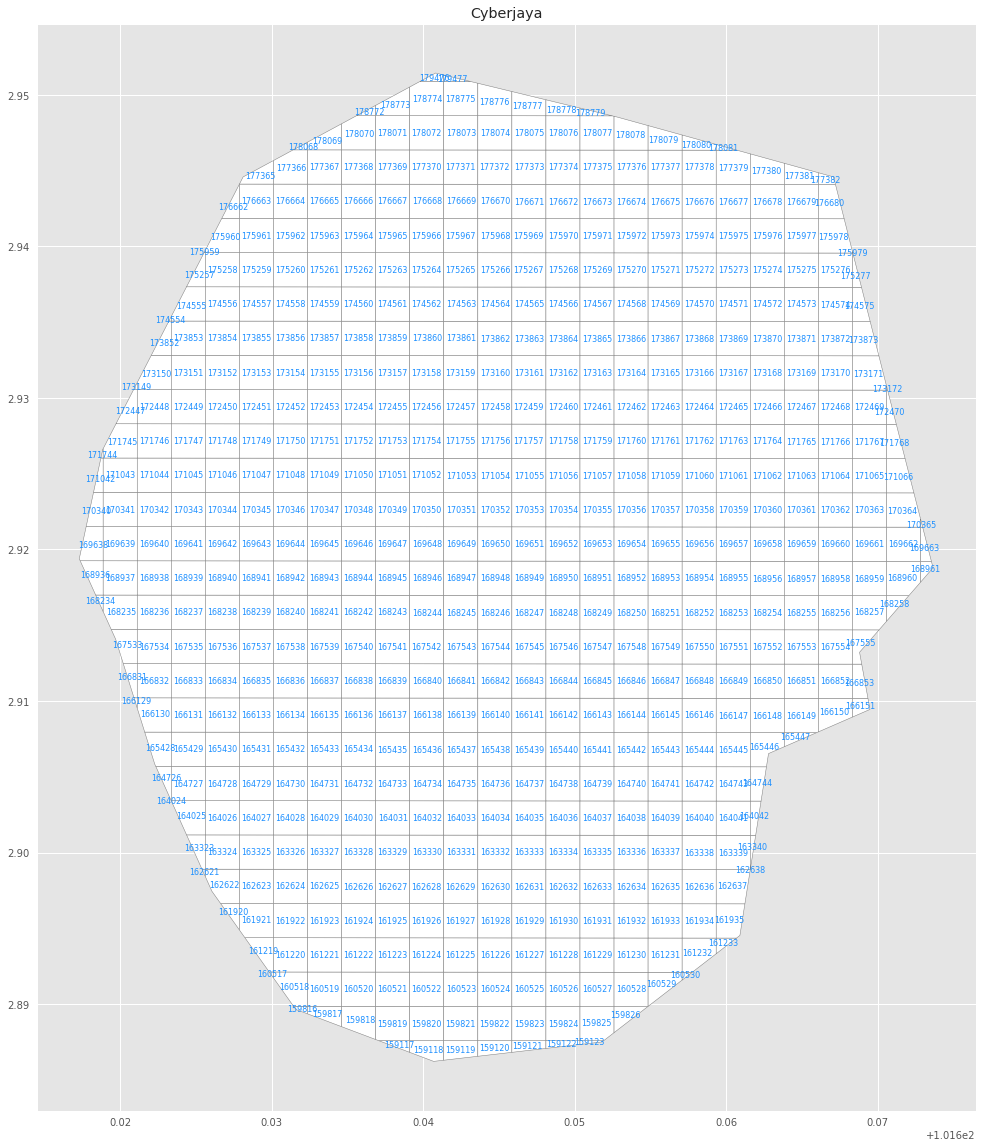

In [3]:
def get_route_centroids(route):
    route_x, route_y = [], []
    for grid_id in route:
        geom = grid_gpd[grid_gpd["grid_id"] == grid_id]["geometry"].values[0]
        route_x.append(geom.centroid.x)
        route_y.append(geom.centroid.y)
    return route_x, route_y

with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(figsize=(20, 20), color="white", edgecolor="grey");
    route_X, route_Y = get_route_centroids(grid_gpd.grid_id.values)
    for i in range(len(route_X)):
        plt.text(route_X[i], route_Y[i], s="%d"%(grid_gpd.grid_id.values[i]), ha="center", va="center", fontsize=8, color="dodgerblue")
    
    plt.title("Cyberjaya")
    
    plt.savefig("cyberjaya.png")

In [4]:
transport_locations = pd.read_csv("Dataset/Transport_location.csv")
transport_locations.head()

POI Name  Latitude  Longitude
0  Gocar Station 1   2.90689  101.65628
1  Gocar Station 2   2.91419  101.65499
2  Gocar Station 3   2.91736  101.65221
3  Gocar Station 4   2.91908  101.65490
4  Gocar Station 5   2.92071  101.65592

In [5]:
print("Number of Gocars : ", sum(transport_locations["POI Name"].str.startswith("Gocar")))
print("Number of Neuron Scooter : ", sum(transport_locations["POI Name"].str.startswith("Neuron electric")))
print("Number of Bus Station : ", sum(transport_locations["POI Name"].str.startswith("bus")))

Number of Gocars :  9
Number of Neuron Scooter :  3
Number of Bus Station :  69


In [6]:
poi = pd.read_csv("Dataset/poi.csv")
poi.head()

Category       SubCategory  Latitude   Longitude  \
0  amenity              cafe  2.924346  101.639315   
1  amenity  community_centre  2.932361  101.647073   
2  amenity      kindergarten  2.918134  101.638630   
3  amenity           parking  2.907380  101.655840   
4  amenity           parking  2.930377  101.641317   

                                             POIName  
0                                      Poolside Cafe  
1                Dewan Masjid Raja Haji Fisabilillah  
2                                       SK Cyberjaya  
3                      Cyberview Solar Farm Car Park  
4  Faculty of management (FOM) Staff Car Park @ M...

## Research Question 1A

In recent years, the population and visitors of Cyberjaya has grown tremendously. Hence, Cyberview is embarking on a data-driven
approach to anticipate and plan for future infrastructure and services. To assist in this endeavour, the town planners would like to get
a rough estimate of the current number of visitors. Calculate average daily subscribers rounded to 2 decimal places for grid IDs in
Cyberjaya listed below for the time period between 2019-07-19 to 2019-08-18 during 0700 to 1500

Grid_id: [172456.0, 172457.0, 171754.0, 171755.0, 171756.0, 171052.0, 171053.0, 171054.0, 171058.0, 170356.0]. 

Kindly also use the shape file provided

In [7]:
event_log = pd.read_csv("Dataset/event_log.csv", sep="\t")
event_log["date_time"] = [datetime.datetime.fromtimestamp(dt) for dt in event_log["date_time"]]

event_log["date_time"] = pd.to_datetime(event_log["date_time"])

event_log = event_log.set_index("date_time")

print(event_log.shape)
event_log.head()

(993184, 2)


customer_id   grid_id
date_time                                         
2019-07-19 13:00:00  h092861261790079492  166839.0
2019-07-19 13:01:00  k438071835109624353  168252.0
2019-07-19 13:06:00  1481701602817207678  179477.0
2019-07-19 13:06:00  5368934103184310830  170354.0
2019-07-19 13:09:00  u832408493379095560  175968.0

In [8]:
print("Unique Customers : %d"%len(event_log["customer_id"].unique()))

Unique Customers : 67799


In [9]:
focused_grid_ids = [172456.0, 172457.0, 171754.0, 171755.0, 171756.0, 
                    171052.0, 171053.0, 171054.0, 171058.0, 170356.0]

In [10]:
event_log_focused_grids = event_log[event_log.grid_id.isin(focused_grid_ids)]
event_log_focused_grids.head()

customer_id   grid_id
date_time                                         
2019-07-19 13:17:00  l608040856396457179  171054.0
2019-07-19 13:18:00  l130298555878804814  171755.0
2019-07-19 13:28:00  6848612498816778337  171054.0
2019-07-19 13:30:00  1180346010025704896  170356.0
2019-07-19 13:40:00  k591611459331266212  171058.0

In [11]:
event_log_focused_grids.tail()

customer_id   grid_id
date_time                                         
2019-08-18 18:06:00  r837703671297589518  171756.0
2019-08-18 18:10:00  2279952286328536114  170356.0
2019-08-18 18:11:00  u116487898143985704  171756.0
2019-08-18 18:28:00  r855840276738336432  170356.0
2019-08-18 20:15:00  h639099876417332055  172456.0

In [12]:
dt_rng1 = pd.date_range(start="2019-07-19 07:00:00", end="2019-08-19")
dt_rng2 = pd.date_range(start="2019-07-19 15:00:00", end="2019-08-19")

In [13]:
dfs = []
for dt1, dt2 in zip(dt_rng1, dt_rng2):
    temp_df = event_log_focused_grids[(event_log_focused_grids.index >= dt1) & (event_log_focused_grids.index <= dt2)].copy()
    dfs.append(temp_df)

In [14]:
event_log_time_rng = pd.concat(dfs)
event_log_time_rng = event_log_time_rng.reset_index()
event_log_time_rng.head()

date_time          customer_id   grid_id
0 2019-07-19 13:17:00  l608040856396457179  171054.0
1 2019-07-19 13:18:00  l130298555878804814  171755.0
2 2019-07-19 13:28:00  6848612498816778337  171054.0
3 2019-07-19 13:30:00  1180346010025704896  170356.0
4 2019-07-19 13:40:00  k591611459331266212  171058.0

In [15]:
#final_df["date"] = [dt.date() for dt in final_df.date_time]
#final_df.head()

In [16]:
avg_subscriber_per_grid = event_log_time_rng.groupby(by=["grid_id"]).count()/len(dt_rng1)
avg_subscriber_per_grid = avg_subscriber_per_grid[["customer_id"]].rename(columns={"customer_id": "Avg.SubscribersPerDay"})
avg_subscriber_per_grid = avg_subscriber_per_grid.sort_values("Avg.SubscribersPerDay")
avg_subscriber_per_grid

Avg.SubscribersPerDay
grid_id                        
170356.0               1.806452
171052.0               2.129032
171058.0               2.129032
171053.0               2.258065
171054.0               2.612903
171756.0               2.677419
172456.0               2.709677
171754.0               2.806452
172457.0               3.000000
171755.0               3.322581

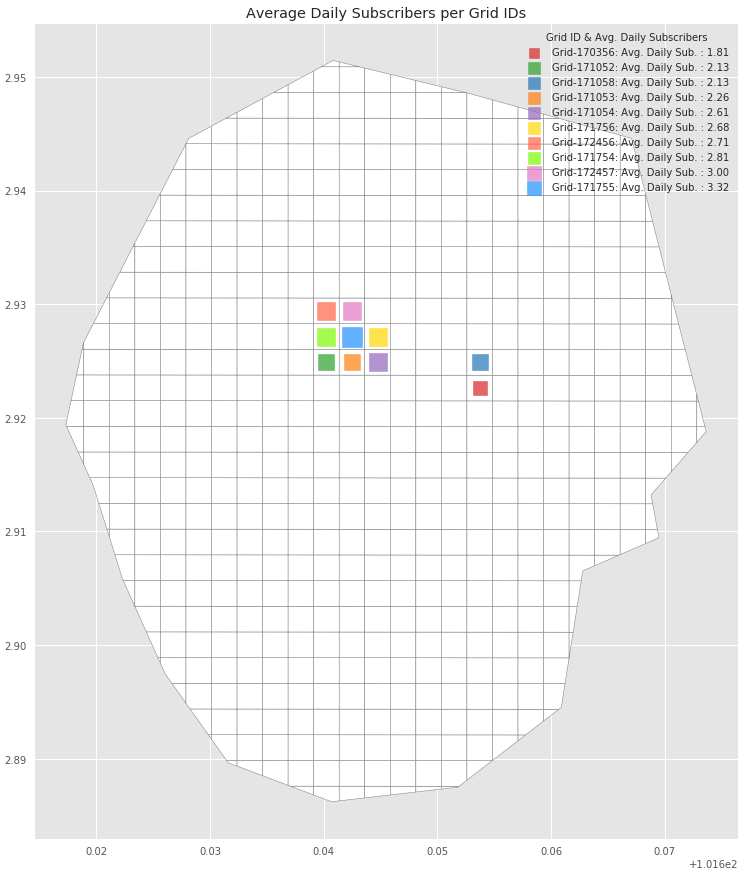

In [19]:
colors = ["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple", "gold",
                "tomato", "lawngreen", "tab:pink", "dodgerblue"]

with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(figsize=(15,15), color="white", edgecolor="grey");
    i=0
    for item in avg_subscriber_per_grid.iterrows():
        avg_sub = item[1]["Avg.SubscribersPerDay"]
        grid_id = item[0]
        
        route_x, route_y = get_route_centroids([grid_id])
        
        plt.scatter(route_x, route_y, c=colors[i], s=avg_sub*120, label="Grid-%d: Avg. Daily Sub. : %.2f"%(int(grid_id), avg_sub), alpha=0.7, marker="s")
        i = i+1
        
    
    plt.legend(loc="best", markerscale=0.7, title="Grid ID & Avg. Daily Subscribers")
    plt.title("Average Daily Subscribers per Grid IDs")
    plt.savefig("Average_Daily_Subscribers_Per_Central_Grids.png")

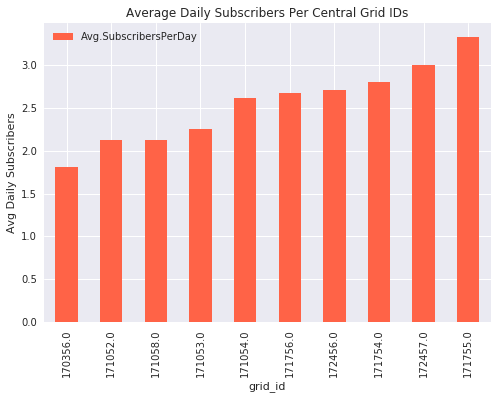

In [21]:
with plt.style.context(("ggplot", "seaborn")):
    avg_subscriber_per_grid.plot.bar(color="tomato")
    plt.ylabel("Avg Daily Subscribers")
    plt.title("Average Daily Subscribers Per Central Grid IDs")

## Research Question 1B

Part of the growth has been attributed to proliferation of the F&B industry. Identify all the Grid ID’s with F&B POIs using the datasets provided

In [22]:
merchant_list = pd.read_csv("Dataset/Merchant_list.csv", sep="\t")
print(merchant_list.shape)
merchant_list.head()

(2034, 4)


MerchantCode           MerchantName MerchantCategory   grid_id
0  0001ak3c5il5         Retail Chain 6           Retail  167546.0
1  0001c35xpel5        Retail Chain 38           Retail  164737.0
2   000831n1c55        Retail Chain 38           Retail  178079.0
3  000aiu0y16t6  Retail Individual 185           Retail  175972.0
4   0012ia2l2l9     F&B Individual 367              F&B  167544.0

In [23]:
fnb_grids = merchant_list[merchant_list.MerchantCategory == 'F&B'].grid_id.unique()
fnb_grids[:10]

array([167544., 169651., 173867., 170342., 166844., 166147., 167535.,
       178076., 171764., 166832.])

In [24]:
fnb_merchants = merchant_list[merchant_list.MerchantCategory == 'F&B']
print(fnb_merchants.shape)
fnb_merchants.head()

(749, 4)


MerchantCode        MerchantName MerchantCategory   grid_id
4    0012ia2l2l9  F&B Individual 367              F&B  167544.0
13   0022n29iio1  F&B Individual 319              F&B  169651.0
15   002lc0l7k18        F&B Chain 57              F&B  173867.0
19  003al37c1lm6        F&B Chain 15              F&B  170342.0
20  003i77nc5he0  F&B Individual 240              F&B  166844.0

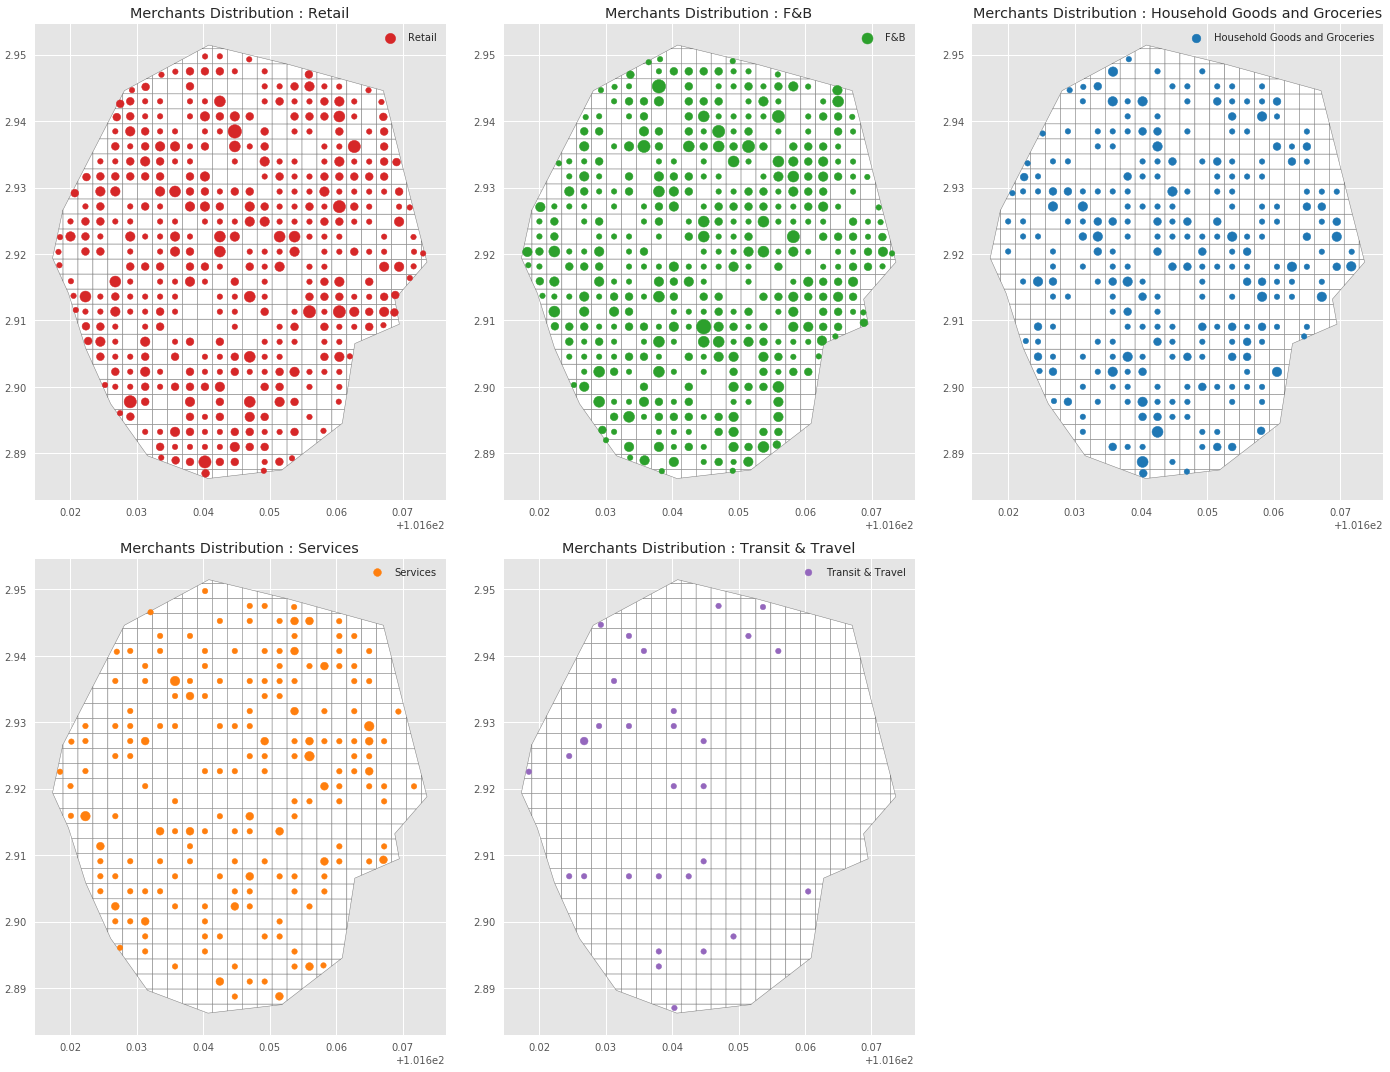

In [26]:
colors = ["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple", "tab:brown"]

with plt.style.context(("seaborn", "ggplot")):
    fig = plt.figure(figsize=(20,15))
    for i, category in enumerate(merchant_list["MerchantCategory"].unique()):
        ax = fig.add_subplot(2,3,(i+1))
        grid_gpd.plot(color="white", edgecolor="grey", ax=ax);
        temp_df = merchant_list[merchant_list.MerchantCategory == category]
        merchants_per_grid = temp_df.groupby(by="grid_id").count()[["MerchantCode"]]
        route_x, route_y = get_route_centroids(merchants_per_grid.index)
        
        plt.scatter(route_x, route_y, s=merchants_per_grid["MerchantCode"]*30, label=category, c=colors[i])
        plt.title("Merchants Distribution : %s"%category)
        plt.legend(loc="best")
        
    plt.tight_layout()
    
    plt.savefig("merchants_distribution.png")

In [27]:
merchant_count_per_cat = merchant_list.groupby(by="MerchantCategory").count()[["MerchantCode"]].rename(columns={"MerchantCode":"Count"})
merchant_count_per_cat = merchant_count_per_cat.sort_values(by="Count")
merchant_count_per_cat

Count
MerchantCategory                    
Transit & Travel                  31
Services                         212
Household Goods and Groceries    364
Retail                           678
F&B                              749

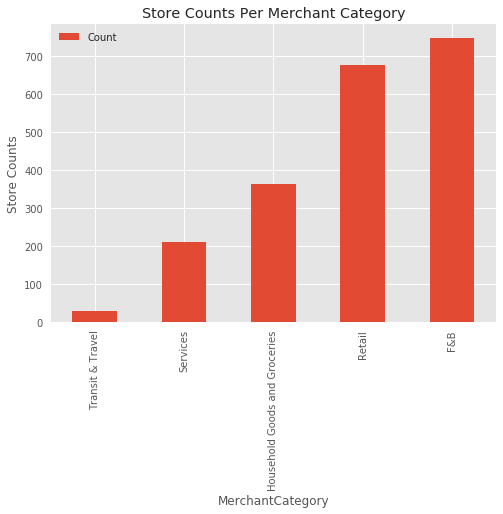

In [28]:
with plt.style.context(("seaborn", "ggplot")):
    merchant_count_per_cat.plot.bar(title="Store Counts Per Merchant Category")
    plt.ylabel("Store Counts")

In [29]:
avg_merchant_per_grid = merchant_count_per_cat/ grid_gpd.shape[0]
avg_merchant_per_grid = avg_merchant_per_grid.sort_values(by="Count")
avg_merchant_per_grid = avg_merchant_per_grid.rename(columns={"Count":"Avg"})
avg_merchant_per_grid

Avg
MerchantCategory                       
Transit & Travel               0.054007
Services                       0.369338
Household Goods and Groceries  0.634146
Retail                         1.181185
F&B                            1.304878

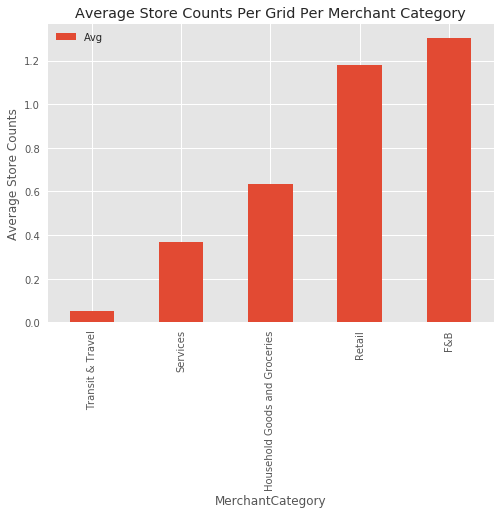

In [30]:
with plt.style.context(("seaborn", "ggplot")):
    avg_merchant_per_grid.plot.bar(title="Average Store Counts Per Grid Per Merchant Category")
    plt.ylabel("Average Store Counts")

## Research Question 1C

Boost is also interested in expanding its footprint in Cyberjaya’s F&B industry as it has a significant number of userbase in Cyberjaya. The ability to identify the most popular F&B locations during lunch hour (1200 to 1400) allows for Boost to refine its F&B merchant acquisition strategy and run better campaigns. From the Grid ID’s identified in Question 1b), state the top 10 Grid ID’s with the highest number of Boost users from 1200 to 1400 and provide the count.

In [31]:
transactions = pd.read_csv("Dataset/transaction.csv", sep="\t")
transactions.head()

customer_id  MerchantCode               MerchantCategory  \
0   r43045724262114812     pmbmkbipk               Transit & Travel   
1   165324620748557838  92r201n2a0iy  Household Goods and Groceries   
2  h233548585934022368   3h00c55uk01  Household Goods and Groceries   
3  6074516273378802718  110o7is610eu                            F&B   
4   860214065958232817  50013tcm50aa  Household Goods and Groceries   

      date_time    GTV  
0  1.563537e+09  31.45  
1  1.563537e+09  17.25  
2  1.563537e+09  88.00  
3  1.563537e+09  50.82  
4  1.563537e+09  16.97

In [32]:
transactions["date_time"] = [datetime.datetime.fromtimestamp(dt) for dt in transactions["date_time"]]
transactions["date_time"] = pd.to_datetime(transactions["date_time"])
transactions = transactions.set_index("date_time")

transactions.head()

customer_id  MerchantCode  \
date_time                                                
2019-07-19 17:16:00   r43045724262114812     pmbmkbipk   
2019-07-19 17:16:00   165324620748557838  92r201n2a0iy   
2019-07-19 17:16:00  h233548585934022368   3h00c55uk01   
2019-07-19 17:16:00  6074516273378802718  110o7is610eu   
2019-07-19 17:16:00   860214065958232817  50013tcm50aa   

                                  MerchantCategory    GTV  
date_time                                                  
2019-07-19 17:16:00               Transit & Travel  31.45  
2019-07-19 17:16:00  Household Goods and Groceries  17.25  
2019-07-19 17:16:00  Household Goods and Groceries  88.00  
2019-07-19 17:16:00                            F&B  50.82  
2019-07-19 17:16:00  Household Goods and Groceries  16.97

In [33]:
transactions.tail()

customer_id  MerchantCode  \
date_time                                                
2019-08-18 20:45:00  z187213436624404561     pmbmkbipk   
2019-08-18 20:46:00  l002275407626230219  si80i94e306c   
2019-08-18 20:46:00  u617042222011677316     pmbmkbipk   
2019-08-18 20:47:00  2398834153335674582  01ca0e53wh05   
2019-08-18 20:53:00   z28125565867803678  1c5enrd00053   

                                  MerchantCategory     GTV  
date_time                                                   
2019-08-18 20:45:00               Transit & Travel   11.33  
2019-08-18 20:46:00                       Services  130.96  
2019-08-18 20:46:00               Transit & Travel   26.12  
2019-08-18 20:47:00  Household Goods and Groceries  165.89  
2019-08-18 20:53:00  Household Goods and Groceries   34.31

In [34]:
transactions.groupby("customer_id").sum()[["GTV"]] / 30

GTV
customer_id                    
1000389532835354059   57.850667
100145068625335576    35.230333
1004944629214078488   81.764667
1005785517217042357   24.423333
1007407006287220756   43.209667
...                         ...
z994875272782766387  101.305667
z994942448259670370   40.358667
z996676812123238095   85.808000
z99671153503406487    47.118667
z998691416986185732   42.873667

[8537 rows x 1 columns]

In [35]:
avg_gtv_per_merchant_cat = pd.pivot_table(transactions, index="customer_id", columns="MerchantCategory", values="GTV")
avg_gtv_per_merchant_cat = avg_gtv_per_merchant_cat/30
avg_gtv_per_merchant_cat = avg_gtv_per_merchant_cat.fillna(0)
avg_gtv_per_merchant_cat.head()

MerchantCategory          F&B  Household Goods and Groceries    Retail  \
customer_id                                                              
1000389532835354059  2.273333                       1.770333  3.208286   
100145068625335576   1.716424                       0.000000  0.946167   
1004944629214078488  1.752745                       0.000000  3.326400   
1005785517217042357  1.790857                       1.371333  0.000000   
1007407006287220756  2.055458                       0.804500  1.687867   

MerchantCategory     Services  Transit & Travel  
customer_id                                      
1000389532835354059  1.795667          0.000000  
100145068625335576   1.445000          0.771156  
1004944629214078488  4.417000          0.000000  
1005785517217042357  0.000000          0.751143  
1007407006287220756  0.274000          0.000000

In [36]:
print("F&B Daily Spend Range : %.2f - %.2f"%(avg_gtv_per_merchant_cat["F&B"].min(), avg_gtv_per_merchant_cat["F&B"].max()))
print("Household Goods and Groceries Daily Spend Range : %.2f - %.2f"%(avg_gtv_per_merchant_cat["Household Goods and Groceries"].min(), avg_gtv_per_merchant_cat["Household Goods and Groceries"].max()))
print("Retail Daily Spend Range : %.2f - %.2f"%(avg_gtv_per_merchant_cat["Retail"].min(), avg_gtv_per_merchant_cat["Retail"].max()))
print("Services Daily Spend Range : %.2f - %.2f"%(avg_gtv_per_merchant_cat["Services"].min(), avg_gtv_per_merchant_cat["Services"].max()))
print("Transit & Travel Daily Spend Range : %.2f - %.2f"%(avg_gtv_per_merchant_cat["Transit & Travel"].min(), avg_gtv_per_merchant_cat["Transit & Travel"].max()))

F&B Daily Spend Range : 0.00 - 11.37
Household Goods and Groceries Daily Spend Range : 0.00 - 32.01
Retail Daily Spend Range : 0.00 - 38.01
Services Daily Spend Range : 0.00 - 33.27
Transit & Travel Daily Spend Range : 0.00 - 18.92


In [37]:
dt_rng1 = pd.date_range(start="2019-07-19 12:00:00", end="2019-08-19")
dt_rng2 = pd.date_range(start="2019-07-19 14:00:00", end="2019-08-19")

In [38]:
dfs = []
for dt1, dt2 in zip(dt_rng1, dt_rng2):
    temp_df = event_log[(event_log.index >= dt1) & (event_log.index <= dt2)].copy()
    dfs.append(temp_df)

In [39]:
event_lunch = pd.concat(dfs)
event_lunch = event_lunch.reset_index()
event_lunch["date"] = [dt.date() for dt in event_lunch["date_time"]]
print(event_lunch.shape)
event_lunch.head()

(6381, 4)


date_time          customer_id   grid_id        date
0 2019-07-19 13:00:00  h092861261790079492  166839.0  2019-07-19
1 2019-07-19 13:01:00  k438071835109624353  168252.0  2019-07-19
2 2019-07-19 13:06:00  1481701602817207678  179477.0  2019-07-19
3 2019-07-19 13:06:00  5368934103184310830  170354.0  2019-07-19
4 2019-07-19 13:09:00  u832408493379095560  175968.0  2019-07-19

In [40]:
event_lunch = event_lunch[event_lunch["grid_id"].isin(fnb_merchants.grid_id.values)]
cust_count_per_grid = event_lunch.groupby("grid_id").count()[["customer_id"]].rename(columns={"customer_id":"Cust.Count"})
cust_count_per_grid = cust_count_per_grid.sort_values("Cust.Count", ascending=False)
#cust_count_per_grid = cust_count_per_grid/len(dt_rng1)
cust_count_per_grid.head(10)

Cust.Count
grid_id             
177365.0          42
178772.0          34
164744.0          27
165447.0          25
178071.0          22
169650.0          21
175266.0          20
173160.0          20
177375.0          20
173155.0          20

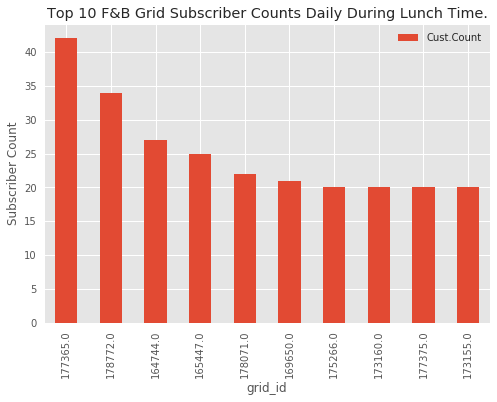

In [45]:
with plt.style.context(("seaborn", "ggplot")):
    cust_count_per_grid.head(10).plot.bar(title="Top 10 F&B Grid Subscriber Counts Daily During Lunch Time.")
    plt.ylabel("Subscriber Count")

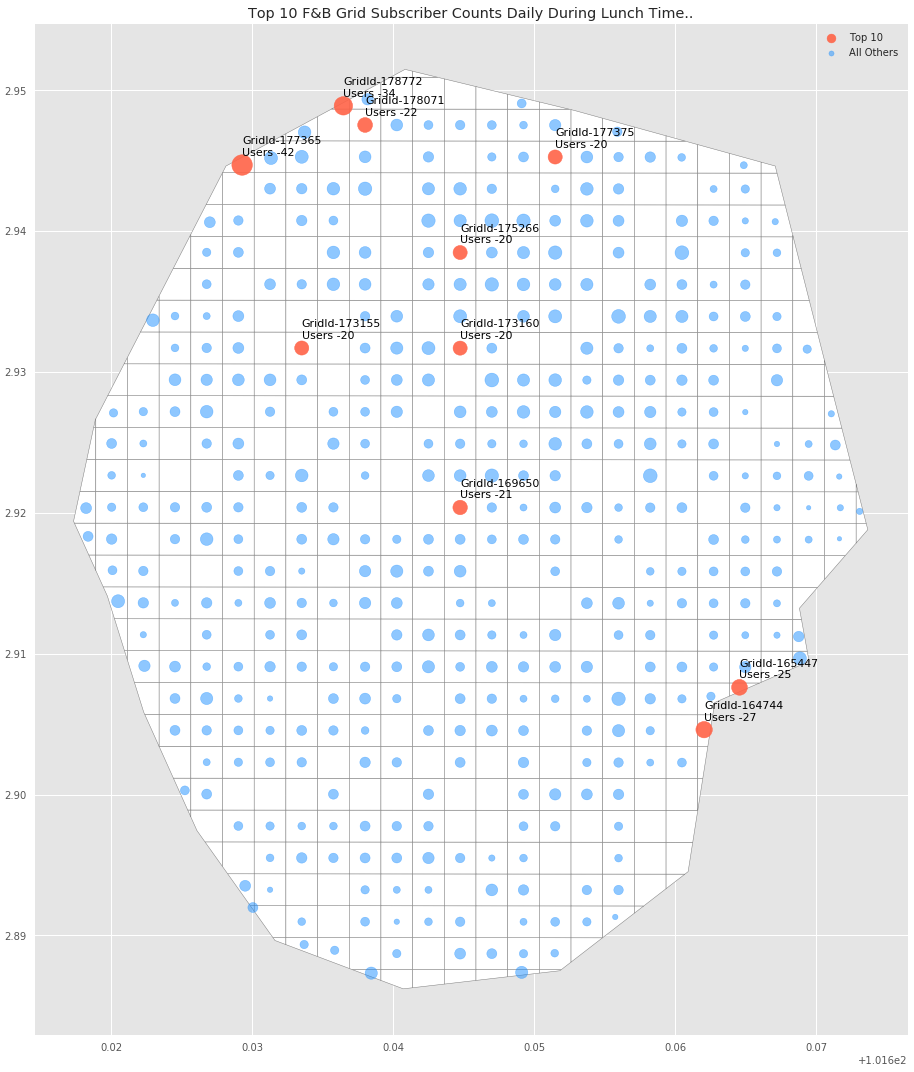

In [46]:
with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(color="white", edgecolor="grey", figsize=(15,15));
    route_x, route_y = get_route_centroids(cust_count_per_grid.index[:10])
    plt.scatter(route_x, route_y, 
                s=cust_count_per_grid["Cust.Count"].values[:10]*10, 
                c="tomato", 
                label="Top 10",
                alpha=0.9)
        
    for grid_id, size in zip(cust_count_per_grid.index[:10], cust_count_per_grid["Cust.Count"].values[:10]):
        route_x, route_y = get_route_centroids([grid_id])
        plt.text(route_x[0], route_y[0]+0.0007, "GridId-%d\nUsers -%d"%(int(grid_id), size), color="black", fontsize=11)
        
    route_x, route_y = get_route_centroids(cust_count_per_grid.index[10:])
    plt.scatter(route_x, route_y,
                s=cust_count_per_grid["Cust.Count"].values[10:]*10, 
                c="dodgerblue",
                label="All Others",
                alpha=0.5)
    
    plt.title("Top 10 F&B Grid Subscriber Counts Daily During Lunch Time..")
    plt.legend(loc="best", markerscale=0.5)
    plt.tight_layout()
    
    plt.savefig("customer_count_per_grid.png")

## Research Question 2A

Currently traffic count is monitored by intelligent cameras at certain main roads in Cyberjaya. Cyberview intends to augment traffic
tracking on roads which is currently not served by these intelligent cameras. Using telco data, develop a method to track road
usage / traffic density from 1200 to 1400 on the 6 main routes listed below. Creatively visualise your output.
N.B. We are looking specifically for mobility / movements. Do account for static subscribers

Route1 grid_id = [173860.0,173861.0,173159.0,173160.0,173161.0,172459.0,172460.0,172461.0,172462.0,172463.0,172464.0]

Route2 grid_id = [173860.0, 173859.0,173157.0,172455.0,171753.0,171051.0,170349.0,169647.0,168945.0,168243.0,167541.0,
166839.0,166137.0,165435.0]

Route3 grid_id = [165435.0,165436.0,165437.0,165438.0,166140.0,166141.0,166843.0,166844.0,166845.0,166846.0,166847.0
,166848.0,166849.0]

Route4 grid_id = [166847.0,167549.0,167550.0,168252.0,168954.0,169656.0,170358.0,171060.0,171762.0,172464.0]

Route5 grid_id = [170361.0,170360.0,171061.0,170359.0,170358.0,170357.0,170356.0,170355.0,169653.0,169652.0,169651.0,
170353.0,170352.0,170351.0,170350.0,170349.0,170348.0,169645.0,169644.0]

Route6 grid_id = [166844.0,167546.0,168248.0,168247.0,168949.0,169651.0,170353.0,171055.0,171757.0,171756.0,172458.0,173160]

In [47]:
dt_rng1 = pd.date_range(start="2019-07-19 12:00:00", end="2019-08-19")
dt_rng2 = pd.date_range(start="2019-07-19 14:00:00", end="2019-08-19")

In [48]:
dfs = []
for dt1, dt2 in zip(dt_rng1, dt_rng2):
    temp_df = event_log[(event_log.index >= dt1) & (event_log.index <= dt2)].copy()
    dfs.append(temp_df)

In [49]:
event_lunch = pd.concat(dfs)
event_lunch = event_lunch.reset_index()

event_lunch["date"] = [dt.date() for dt in event_lunch["date_time"]]
print(event_lunch.shape)
event_lunch.head()

(6381, 4)


date_time          customer_id   grid_id        date
0 2019-07-19 13:00:00  h092861261790079492  166839.0  2019-07-19
1 2019-07-19 13:01:00  k438071835109624353  168252.0  2019-07-19
2 2019-07-19 13:06:00  1481701602817207678  179477.0  2019-07-19
3 2019-07-19 13:06:00  5368934103184310830  170354.0  2019-07-19
4 2019-07-19 13:09:00  u832408493379095560  175968.0  2019-07-19

In [50]:
route1 = [173860.0,173861.0,173159.0,173160.0,173161.0,172459.0,172460.0,172461.0,172462.0,172463.0,172464.0]

route2 = [173860.0, 173859.0,173157.0,172455.0,171753.0,171051.0,170349.0,169647.0,168945.0,168243.0,167541.0,
166839.0,166137.0,165435.0]

route3 = [165435.0,165436.0,165437.0,165438.0,166140.0,166141.0,166843.0,166844.0,166845.0,166846.0,166847.0
,166848.0,166849.0]
route4 = [166847.0,167549.0,167550.0,168252.0,168954.0,169656.0,170358.0,171060.0,171762.0,172464.0]

route5 = [170361.0,170360.0,171061.0,170359.0,170358.0,170357.0,170356.0,170355.0,169653.0,169652.0,169651.0,
170353.0,170352.0,170351.0,170350.0,170349.0,170348.0,169645.0,169644.0]

route6 = [166844.0,167546.0,168248.0,168247.0,168949.0,169651.0,170353.0,171055.0,171757.0,171756.0,172458.0,173160]

In [51]:
lunch_routes_daily = []
for data in event_lunch.groupby(by=["date", "customer_id"]):
    #print(df[1].shape)
    lunch_routes_daily.append([data[0][0], sorted(data[1].grid_id.values.tolist())])
    
lunch_routes_daily[:5]

[[datetime.date(2019, 7, 19), [166838.0]],
 [datetime.date(2019, 7, 19), [160520.0]],
 [datetime.date(2019, 7, 19), [163335.0]],
 [datetime.date(2019, 7, 19), [170356.0]],
 [datetime.date(2019, 7, 19), [162637.0]]]

In [52]:
def check_route_part_of_any_of_six_routes(route):
    route_s = set(route)
    if route_s.issubset(route1) or route_s.issubset(route2) or route_s.issubset(route3)\
        or route_s.issubset(route4) or route_s.issubset(route5) or route_s.issubset(route6):
        return True
    
    return False

lunch_routes = []

for date, route in lunch_routes_daily:
    if check_route_part_of_any_of_six_routes(route):
        lunch_routes.append(route)

In [53]:
route_counts = []
unique_routes = []
for route in lunch_routes:
    if route not in unique_routes:
        unique_routes.append(route)
        route_counts.append([route, lunch_routes.count(route)])

In [54]:
routes_df = pd.DataFrame(route_counts, columns=["Route", "Count"])
routes_df["Count"] = routes_df["Count"]/len(dt_rng1) 

routes_df.head()

Route     Count
0  [170356.0]  0.290323
1  [169656.0]  0.290323
2  [173157.0]  0.258065
3  [172459.0]  0.580645
4  [168945.0]  0.290323

In [55]:
routes_df.tail()

Route     Count
67            [165436.0]  0.225806
68            [166137.0]  0.290323
69            [172464.0]  0.322581
70  [169652.0, 169653.0]  0.032258
71  [169647.0, 169647.0]  0.032258

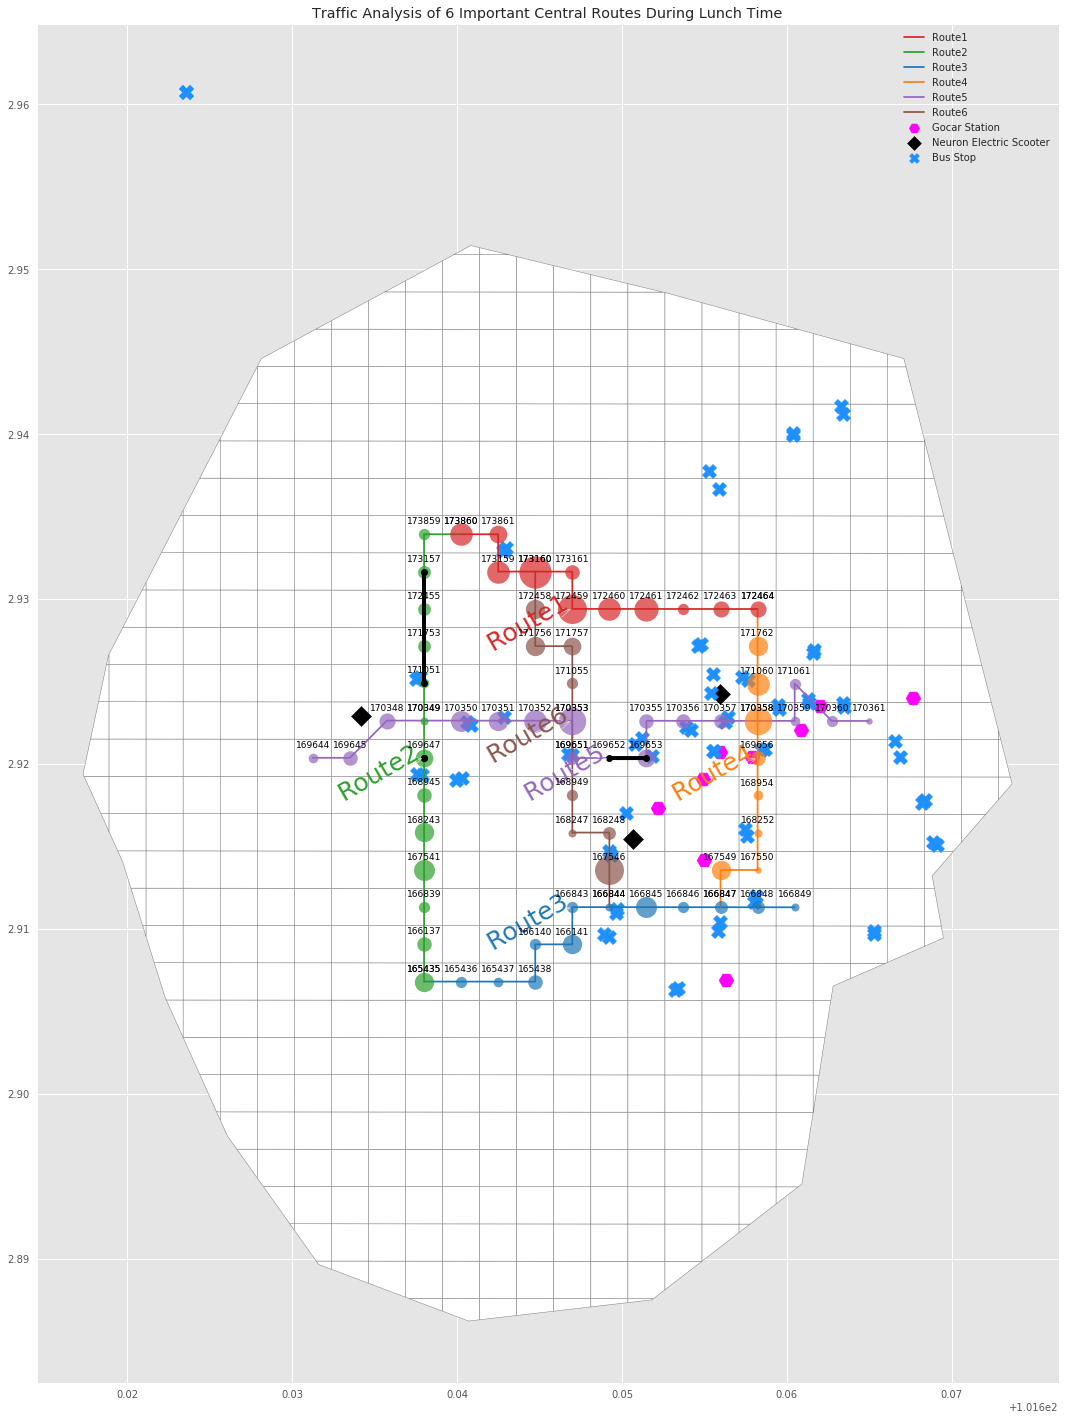

In [57]:
def get_route_centroids(route):
    route_x, route_y = [], []
    for grid_id in route:
        geom = grid_gpd[grid_gpd["grid_id"] == grid_id]["geometry"].values[0]
        route_x.append(geom.centroid.x)
        route_y.append(geom.centroid.y)
    return route_x, route_y

route_colors = ["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple", "tab:brown"]

with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(figsize=(25,25), color="white", edgecolor="grey");
    
    for i, route in enumerate([route1, route2, route3, route4, route5, route6]):
        route_x, route_y = get_route_centroids(route)
        plt.plot(route_x, route_y, c=route_colors[i], label="Route%d"%(i+1))
        plt.annotate("Route%d"%(i+1), 
                     xy=(route_x[len(route_x)//2], route_y[len(route_x)//2]),
                     xycoords='data',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                     horizontalalignment="right",
                     #verticalalignment="bottom",
                     color=route_colors[i],
                     size=25,
                     rotation=30) 
        
        for x,y, grid_id in zip(route_x, route_y, route):
            plt.text(x,y+0.0005, str(int(grid_id)), ha="center", va="bottom", fontsize=9, color="black")
            
    
    go_cars = transport_locations[transport_locations["POI Name"].str.startswith("Gocar Station")]
    plt.scatter(go_cars["Longitude"], go_cars["Latitude"], c="magenta", alpha=1.0, marker="H", s=220, label="Gocar Station")
    
    scooters = transport_locations[transport_locations["POI Name"].str.startswith("Neuron electric scooter Station")]
    plt.scatter(scooters["Longitude"], scooters["Latitude"], c="black", alpha=1.0, marker="D", s=200, label="Neuron Electric Scooter")
    
    bus_stops = transport_locations[transport_locations["POI Name"].str.startswith("bus stop")]
    plt.scatter(bus_stops["Longitude"], bus_stops["Latitude"], c="dodgerblue", marker="X", alpha=1.0, s=200, label="Bus Stop")
    
    #for i, category in enumerate(poi["Category"].unique()):
    #    temp_df = poi[poi.Category == category]
    #    plt.scatter(temp_df.Longitude, temp_df.Latitude, c="red", label=category.upper(), marker="$%s$"%category[0].upper(),alpha=0.8, s=80)
    plt.title("Traffic Analysis of 6 Important Central Routes During Lunch Time")
    plt.legend(loc="best", markerscale=0.7,)
        
    for item in routes_df.iterrows():
        route = item[1].Route
        route_idx  = 1 if route[0] in route1 else 2 if route[0] in route2 else 3 if route[0] in route3 else 4 if route[0] in route4 else 5 if route[0] in route5 else 6 
        route_x, route_y = get_route_centroids(route)
        if len(route_x) == 1:
            plt.plot(route_x, route_y, marker="o", markersize=item[1].Count*50, c=route_colors[route_idx-1], alpha=0.7)
        else:
            plt.plot(route_x, route_y, marker="o", linewidth=4, c="black")
    
    plt.savefig("six_routes.png")

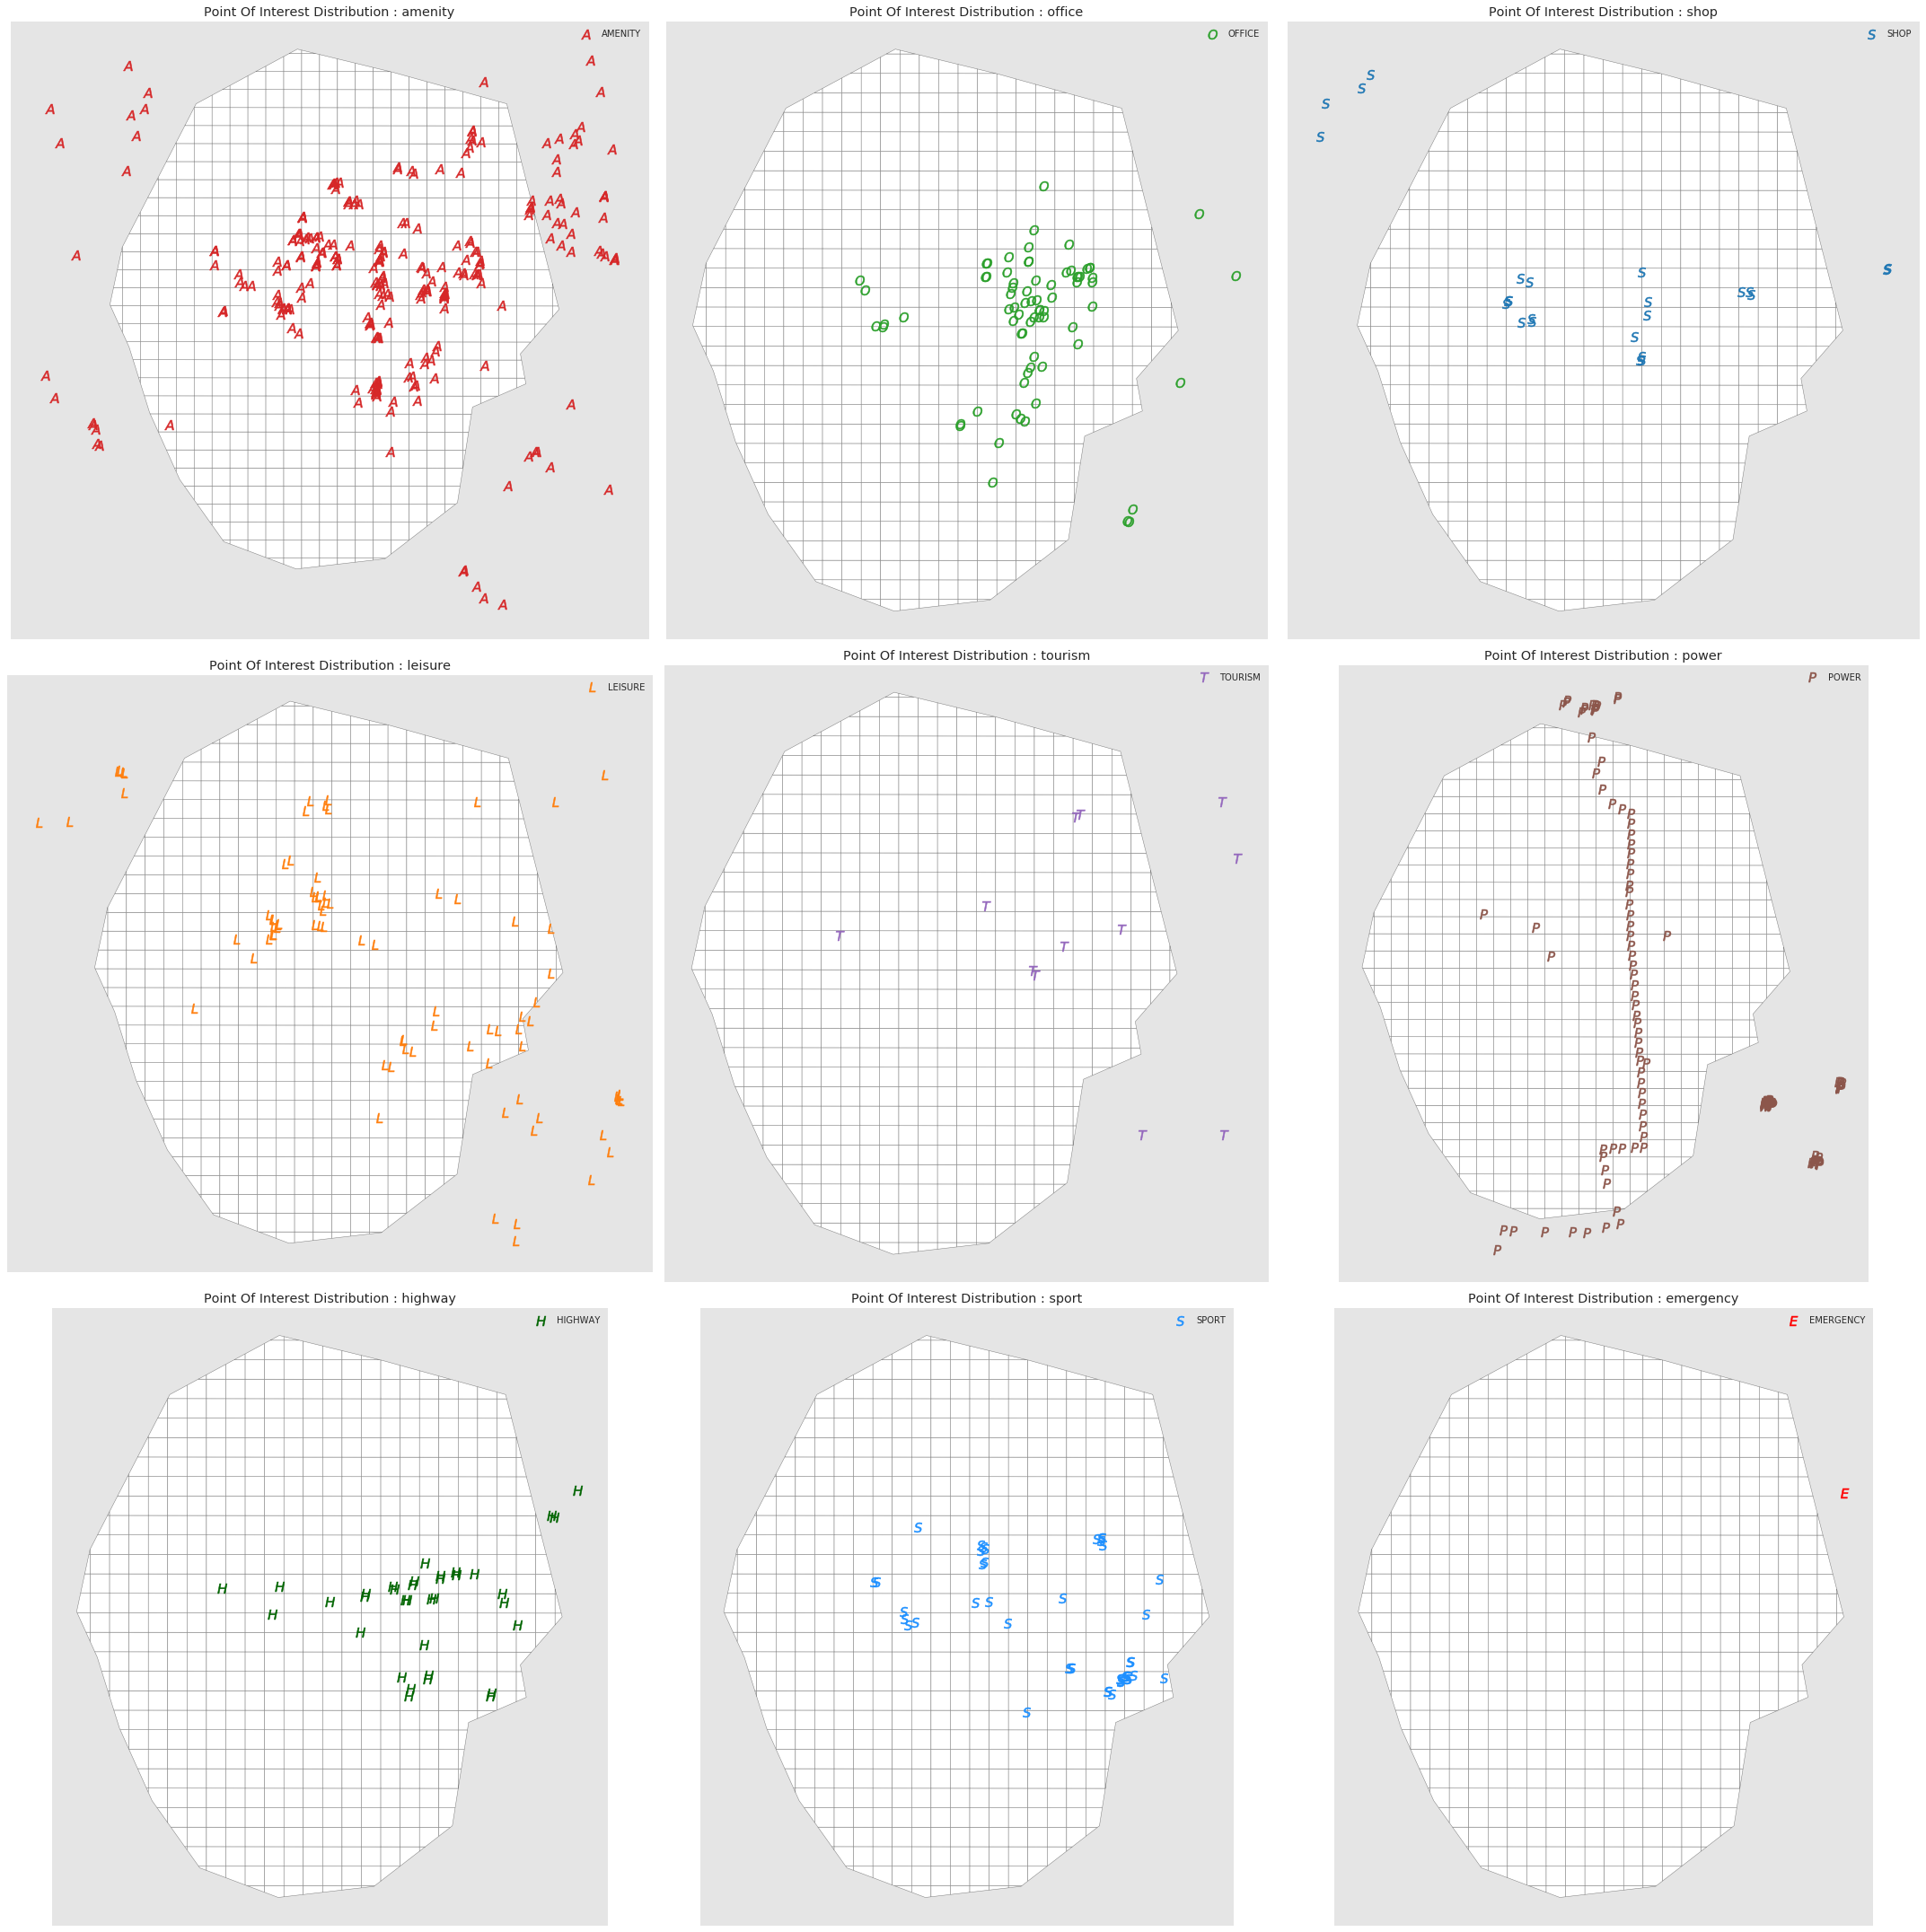

In [58]:
colors = ["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple", "tab:brown", "darkgreen", "dodgerblue", "red"]

with plt.style.context(("seaborn", "ggplot")):
    fig = plt.figure(figsize=(30,30))
    for i, category in enumerate(poi["Category"].unique()):
        ax = fig.add_subplot(3,3,(i+1))
        grid_gpd.plot(color="white", edgecolor="grey", ax=ax);
        temp_df = poi[poi.Category == category]
        plt.scatter(temp_df.Longitude, temp_df.Latitude, c=colors[i], label=category.upper(), marker="$%s$"%category[0].upper(), alpha=1.0, s=120,)
        plt.legend(loc="best")
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
        plt.title("Point Of Interest Distribution : %s"%category)
    plt.savefig("poi.png")

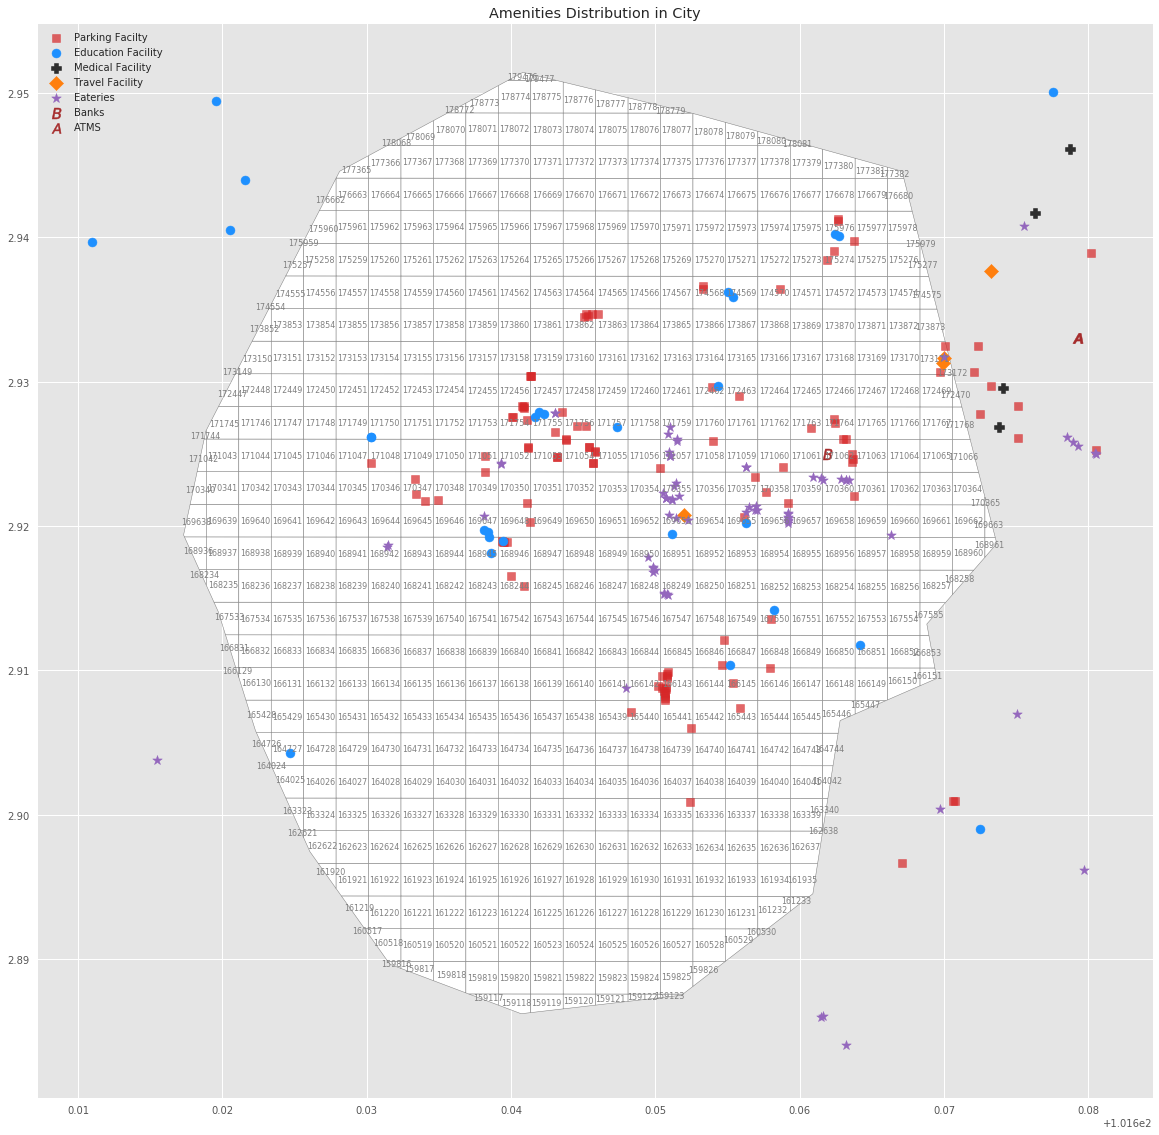

In [59]:
parkings = poi[(poi["Category"]=='amenity') & (poi["SubCategory"].isin(["parking", "parking_space"]))]
education = poi[(poi["Category"]=='amenity') & (poi["SubCategory"].isin(["kindergarten", "school", "university", "library", "college"]))]
medical = poi[(poi["Category"]=='amenity') & (poi["SubCategory"].isin(["hospital", "clinic",]))]
travel = poi[(poi["Category"]=='amenity') & (poi["SubCategory"].isin(["bus_station", "taxi",]))]
eateries = poi[(poi["Category"]=='amenity') & (poi["SubCategory"].isin(["cafe", "restaurant", "fast_food", "food_court"]))]
banks = poi[(poi["Category"]=='amenity') & (poi["SubCategory"].isin(["bank"]))]
atms = poi[(poi["Category"]=='amenity') & (poi["SubCategory"].isin(["atm"]))]

with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(color="white", edgecolor="grey", figsize=(20,20));
    route_X, route_Y = get_route_centroids(grid_gpd.grid_id.values)
    for i in range(len(route_X)):
        plt.text(route_X[i], route_Y[i], s="%d"%(grid_gpd.grid_id.values[i]), ha="center", va="center", fontsize=8, color="grey")
    
    plt.scatter(x=parkings["Longitude"], y=parkings["Latitude"], s=80, c="tab:red", alpha=0.7, marker="s", label="Parking Facilty")
    plt.scatter(x=education["Longitude"], y=education["Latitude"], s=80, c="dodgerblue", alpha=1.0, label="Education Facility")
    plt.scatter(x=medical["Longitude"], y=medical["Latitude"], s=100, c="black", alpha=0.8, marker="P", label="Medical Facility")
    plt.scatter(x=travel["Longitude"], y=travel["Latitude"], s=100, c="tab:orange", alpha=1.0, marker="D", label="Travel Facility")
    plt.scatter(x=eateries["Longitude"], y=eateries["Latitude"], s=100, c="tab:purple", alpha=1.0, marker="*", label="Eateries")
    plt.scatter(x=banks["Longitude"], y=banks["Latitude"], s=120, c="brown", alpha=1.0, marker="$B$", label="Banks")
    plt.scatter(x=atms["Longitude"], y=atms["Latitude"], s=100, c="brown", alpha=1.0, marker="$A$", label="ATMS")

    plt.legend(loc="best")
    plt.title("Amenities Distribution in City")
    plt.savefig("amenities.png")

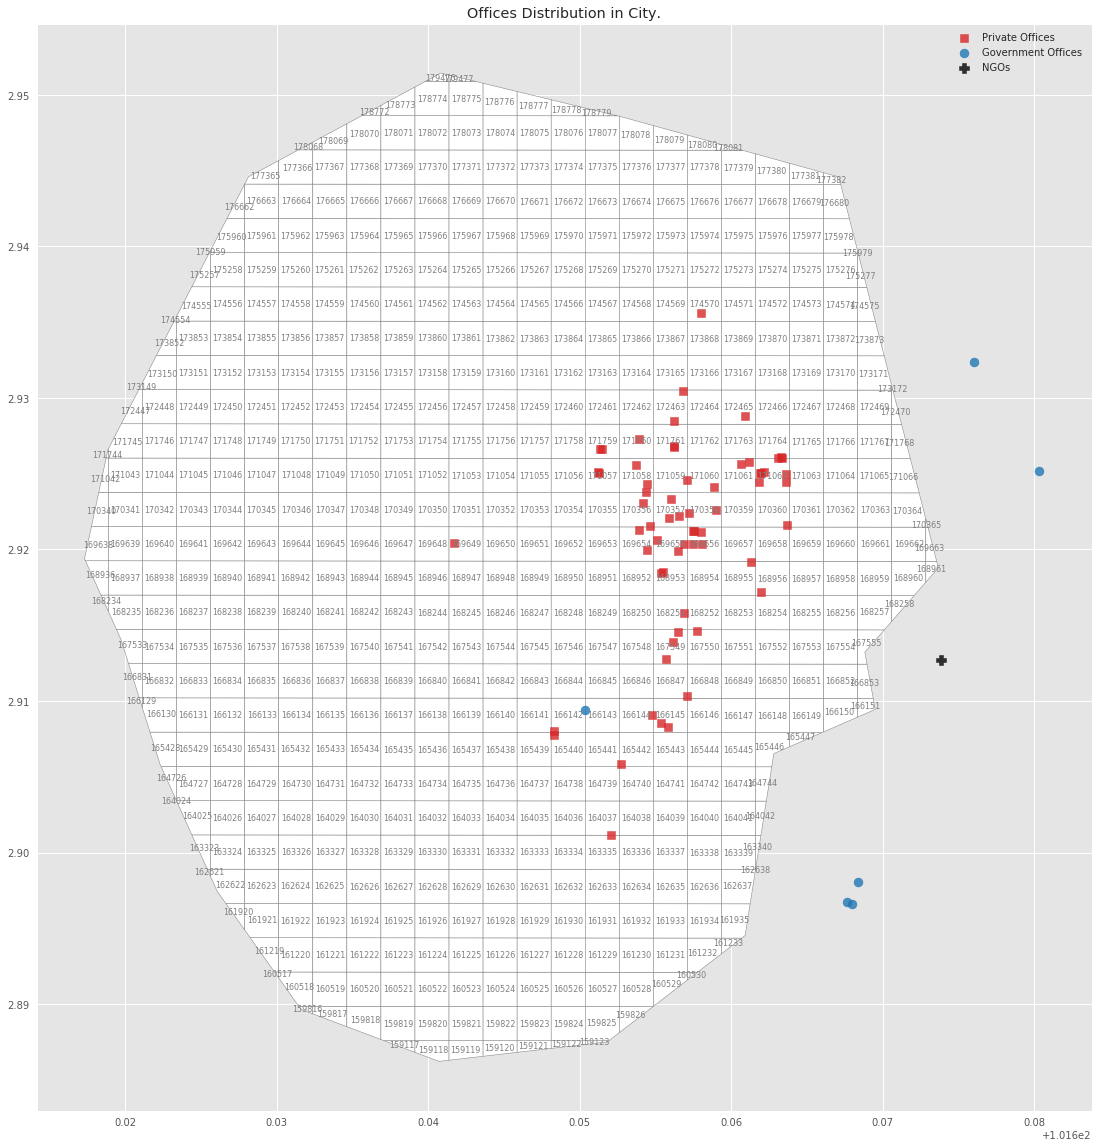

In [60]:
private = poi[(poi["Category"]=='office') & (poi["SubCategory"].isin(["company"]))]
govt = poi[(poi["Category"]=='office') & (poi["SubCategory"].isin(["government",]))]
ngos = poi[(poi["Category"]=='office') & (poi["SubCategory"].isin(["ngo",]))]

with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(color="white", edgecolor="grey", figsize=(20,20));
    route_X, route_Y = get_route_centroids(grid_gpd.grid_id.values)
    for i in range(len(route_X)):
        plt.text(route_X[i], route_Y[i], s="%d"%(grid_gpd.grid_id.values[i]), ha="center", va="center", fontsize=8, color="grey")
    
    plt.scatter(x=private["Longitude"], y=private["Latitude"], s=80, c="tab:red", alpha=0.8, marker="s", label="Private Offices")
    plt.scatter(x=govt["Longitude"], y=govt["Latitude"], s=80, c="tab:blue", alpha=0.8, label="Government Offices")
    plt.scatter(x=ngos["Longitude"], y=ngos["Latitude"], s=100, c="black", alpha=0.8, marker="P", label="NGOs")

    plt.legend(loc="best")
    plt.title("Offices Distribution in City.")
    plt.savefig("offices.png")

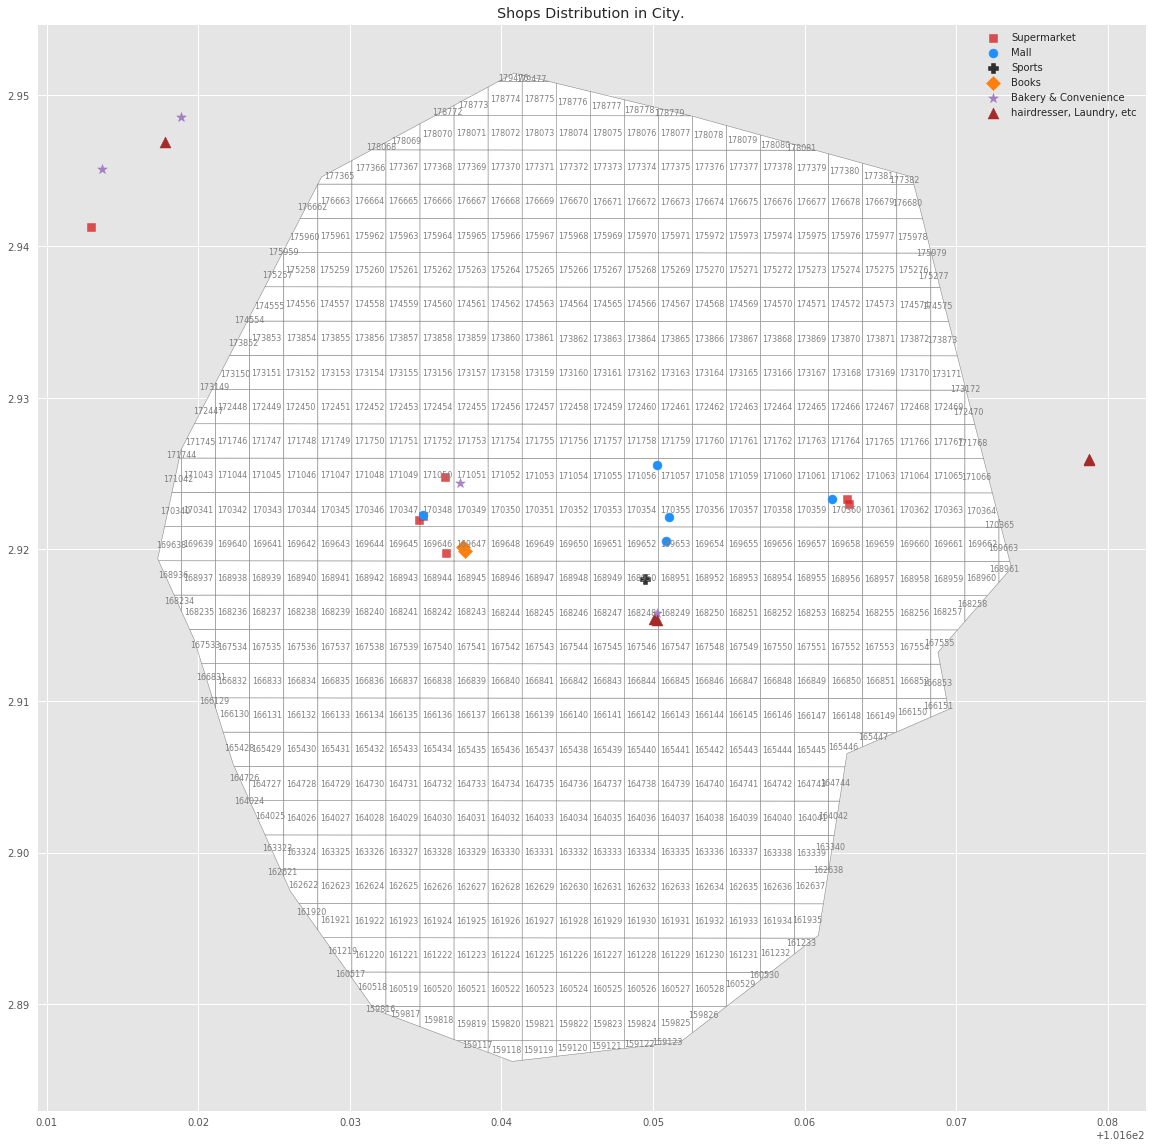

In [61]:
supermarket = poi[(poi["Category"]=='shop') & (poi["SubCategory"].isin(["supermarket",]))]
mall = poi[(poi["Category"]=='shop') & (poi["SubCategory"].isin(["mall", ]))]
sport = poi[(poi["Category"]=='shop') & (poi["SubCategory"].isin(["sport",]))]
books = poi[(poi["Category"]=='shop') & (poi["SubCategory"].isin(["books"]))]
convenience = poi[(poi["Category"]=='shop') & (poi["SubCategory"].isin(["convenience", "bakery", ]))]
other = poi[(poi["Category"]=='shop') & (poi["SubCategory"].isin(["hairdresser", "laundry", "hardware", "maternity"]))]

with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(color="white", edgecolor="grey", figsize=(20,20));
    route_X, route_Y = get_route_centroids(grid_gpd.grid_id.values)
    for i in range(len(route_X)):
        plt.text(route_X[i], route_Y[i], s="%d"%(grid_gpd.grid_id.values[i]), ha="center", va="center", fontsize=8, color="grey")
    
    plt.scatter(x=supermarket["Longitude"], y=supermarket["Latitude"], s=80, c="tab:red", alpha=0.8, marker="s", label="Supermarket")
    plt.scatter(x=mall["Longitude"], y=mall["Latitude"], s=80, c="dodgerblue", alpha=1.0, label="Mall")
    plt.scatter(x=sport["Longitude"], y=sport["Latitude"], s=100, c="black", alpha=0.8, marker="P", label="Sports")
    plt.scatter(x=books["Longitude"], y=books["Latitude"], s=100, c="tab:orange", alpha=1.0, marker="D", label="Books")
    plt.scatter(x=convenience["Longitude"], y=convenience["Latitude"], s=100, c="tab:purple", alpha=0.8, marker="*", label="Bakery & Convenience")
    plt.scatter(x=other["Longitude"], y=other["Latitude"], s=120, c="brown", alpha=1.0, marker="^", label="hairdresser, Laundry, etc")
    #plt.scatter(x=atms["Longitude"], y=atms["Latitude"], s=100, c="brown", alpha=1.0, marker="$A$", label="ATMS")

    plt.legend(loc="best")
    plt.title("Shops Distribution in City.")
    plt.savefig("shops.png")

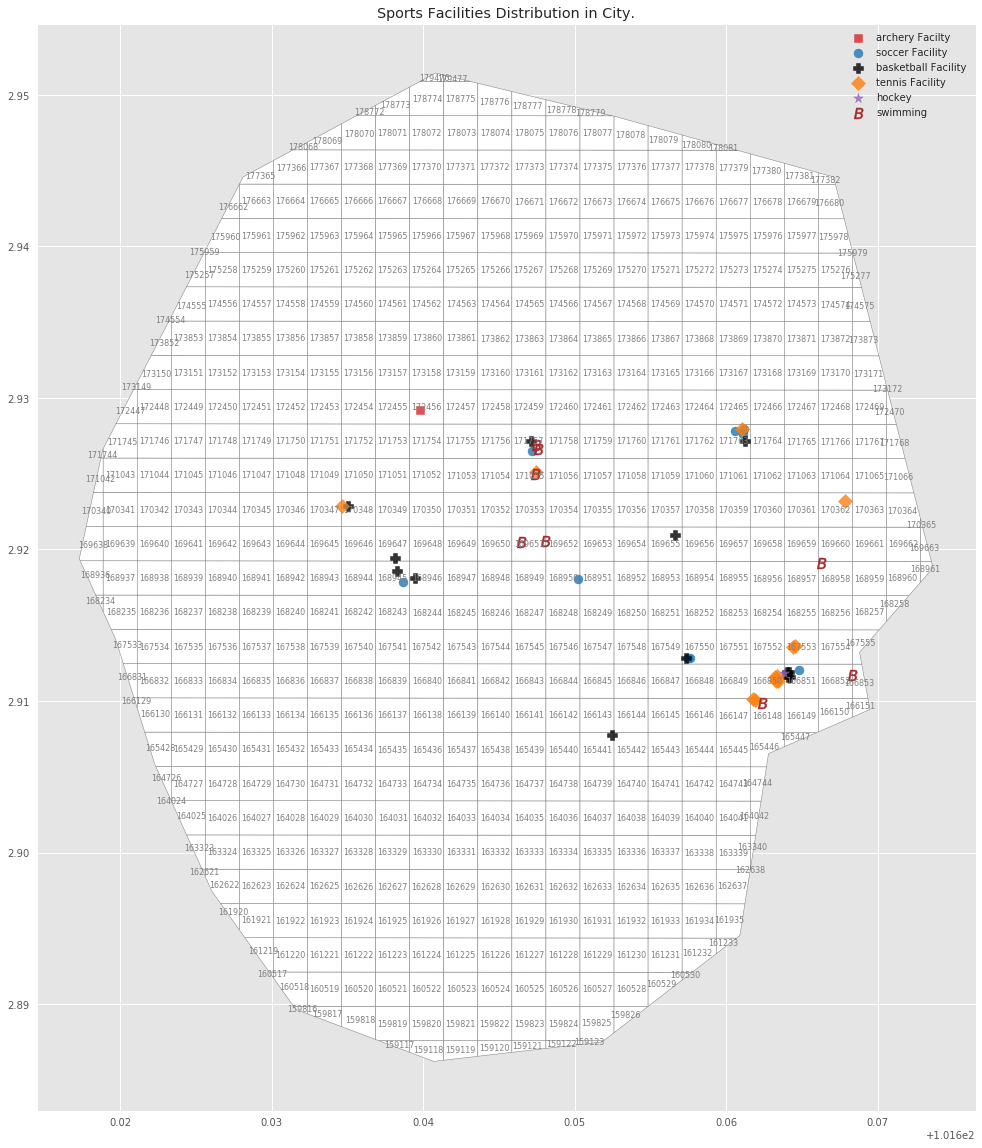

In [62]:
archery = poi[(poi["Category"]=='sport') & (poi["SubCategory"].isin(["archery", ]))]
soccer = poi[(poi["Category"]=='sport') & (poi["SubCategory"].isin(["soccer", ]))]
basketball = poi[(poi["Category"]=='sport') & (poi["SubCategory"].isin(["basketball", ]))]
tennis = poi[(poi["Category"]=='sport') & (poi["SubCategory"].isin(["tennis", ]))]
hockey = poi[(poi["Category"]=='sport') & (poi["SubCategory"].isin(["hockey",]))]
swimming = poi[(poi["Category"]=='sport') & (poi["SubCategory"].isin(["swimming"]))]

with plt.style.context(("seaborn", "ggplot")):
    grid_gpd.plot(color="white", edgecolor="grey", figsize=(20,20));
    route_X, route_Y = get_route_centroids(grid_gpd.grid_id.values)
    for i in range(len(route_X)):
        plt.text(route_X[i], route_Y[i], s="%d"%(grid_gpd.grid_id.values[i]), ha="center", va="center", fontsize=8, color="grey")
    
    plt.scatter(x=archery["Longitude"], y=archery["Latitude"], s=80, c="tab:red", alpha=0.8, marker="s", label="archery Facilty")
    plt.scatter(x=soccer["Longitude"], y=soccer["Latitude"], s=80, c="tab:blue", alpha=0.8, label="soccer Facility")
    plt.scatter(x=basketball["Longitude"], y=basketball["Latitude"], s=100, c="black", alpha=0.8, marker="P", label="basketball Facility")
    plt.scatter(x=tennis["Longitude"], y=tennis["Latitude"], s=100, c="tab:orange", alpha=0.8, marker="D", label="tennis Facility")
    plt.scatter(x=hockey["Longitude"], y=hockey["Latitude"], s=100, c="tab:purple", alpha=0.8, marker="*", label="hockey")
    plt.scatter(x=swimming["Longitude"], y=swimming["Latitude"], s=120, c="brown", alpha=1.0, marker="$B$", label="swimming")
    #plt.scatter(x=atms["Longitude"], y=atms["Latitude"], s=100, c="brown", alpha=1.0, marker="$A$", label="ATMS")

    plt.legend(loc="best")
    plt.title("Sports Facilities Distribution in City.")
    plt.savefig("sports.png")

## Research Question 2B

Air quality is one of the major concerns among Malaysians and air sensors are deployed across Cyberjaya to measure air quality. Using data from one of the air sensors stored in “air_sensor.json”, build a model to forecast air quality (pm25) from 2019-07-01 to 2019-07-07 on an hourly interval from 0000 to 2300 for each day.

In [54]:
air_sensor = pd.read_json("Dataset/air_sensor.json")

air_sensor["date_time"] = [datetime.datetime.fromtimestamp(dt) for dt in air_sensor["CreatedDateTime"]]
air_sensor["date_time"] = pd.to_datetime(air_sensor["date_time"])

air_sensor = air_sensor[(air_sensor.DisplayName == "pm25") & (air_sensor.Status == "Normal")]

air_sensor["_id"] = [device["$oid"] for device in air_sensor["_id"]]

print(air_sensor.shape)
air_sensor.head(10)

(13672, 11)


CreatedDateTime  DeviceDataTypeId  DeviceId DisplayName FabrickName  Name  \
2        1558483742                 5        96        pm25        pm25  pm25   
3        1558486083                 5        96        pm25        pm25  pm25   
4        1558532656                 5        96        pm25        pm25  pm25   
5        1558959582                 5        96        pm25        pm25  pm25   
11       1558959700                 5        96        pm25        pm25  pm25   
18       1558959816                 5        96        pm25        pm25  pm25   
24       1558960635                 5        96        pm25        pm25  pm25   
31       1558960752                 5        96        pm25        pm25  pm25   
38       1558960869                 5        96        pm25        pm25  pm25   
44       1558960986                 5        96        pm25        pm25  pm25   

    Status   Unit  Value                       _id           date_time  
2   Normal  ug/m3   35.0  5ce4935d31b728505c55b058 2019-05-22 05:39:02  
3   Normal  ug/m3   29.0  5ce49c8131b7280a6c4cf591 2019-05-22 06:18:03  
4   Normal  ug/m3   24.0  5ce5526331b728770169696a 2019-05-22 19:14:16  
5   Normal  ug/m3    9.0  5cebd5f531b728081a4639eb 2019-05-27 17:49:42  
11  Normal  ug/m3   10.0  5cebd66d31b7280a80224e04 2019-05-27 17:51:40  
18  Normal  ug/m3    9.0  5cebd6e531b7280d9c34f621 2019-05-27 17:53:36  
24  Normal  ug/m3   10.0  5cebda2d31b72821af61d501 2019-05-27 18:07:15  
31  Normal  ug/m3   11.0  5cebdaa531b72824585fcb6f 2019-05-27 18:09:12  
38  Normal  ug/m3   11.0  5cebdb1d31b72827840bcc61 2019-05-27 18:11:09  
44  Normal  ug/m3   12.0  5cebdb9531b7282a060fe541 2019-05-27 18:13:06

In [55]:
air_sensor.tail()

CreatedDateTime  DeviceDataTypeId  DeviceId DisplayName FabrickName  \
82037       1558957360                 5        96        pm25        pm25   
82043       1558958530                 5        96        pm25        pm25   
82050       1558958647                 5        96        pm25        pm25   
82056       1558958764                 5        96        pm25        pm25   
82063       1558959231                 5        96        pm25        pm25   

       Name  Status   Unit  Value                       _id  \
82037  pm25  Normal  ug/m3   10.0  5cebcd4931b72850cc10d33e   
82043  pm25  Normal  ug/m3   11.0  5cebd1f931b7286da344eaf1   
82050  pm25  Normal  ug/m3    9.0  5cebd27131b72870ef161311   
82056  pm25  Normal  ug/m3   10.0  5cebd2e931b72873d314ba91   
82063  pm25  Normal  ug/m3    9.0  5cebd48d31b7287d9d085201   

                date_time  
82037 2019-05-27 17:12:40  
82043 2019-05-27 17:32:10  
82050 2019-05-27 17:34:07  
82056 2019-05-27 17:36:04  
82063 2019-05-27 17:43:51

In [56]:
#air_sensor["date"] = [dt.date() for dt in air_sensor["date_time"]]
#air_sensor["hour"] = [dt.hour for dt in air_sensor["date_time"]]
#air_sensor = air_sensor.sort_values(["date", "hour"])
air_sensor["date_time"] = [datetime.datetime(dt.year, dt.month, dt.day, dt.hour) for dt in air_sensor["date_time"]]
air_sensor = air_sensor.sort_values(by="date_time")
air_sensor["hour"] = [dt.hour for dt in air_sensor["date_time"]]


air_sensor.head()

CreatedDateTime  DeviceDataTypeId  DeviceId DisplayName FabrickName  \
2           1558483742                 5        96        pm25        pm25   
60001       1558484913                 5        96        pm25        pm25   
53334       1558484796                 5        96        pm25        pm25   
46668       1558484562                 5        96        pm25        pm25   
40001       1558484327                 5        96        pm25        pm25   

       Name  Status   Unit  Value                       _id  \
2      pm25  Normal  ug/m3   35.0  5ce4935d31b728505c55b058   
60001  pm25  Normal  ug/m3   31.0  5ce497d231b7286c13787fba   
53334  pm25  Normal  ug/m3   31.0  5ce4975a31b728693751f041   
46668  pm25  Normal  ug/m3   34.0  5ce4966a31b728638257e388   
40001  pm25  Normal  ug/m3   31.0  5ce4957a31b7285dc647019d   

                date_time  hour  
2     2019-05-22 05:00:00     5  
60001 2019-05-22 05:00:00     5  
53334 2019-05-22 05:00:00     5  
46668 2019-05-22 05:00:00     5  
40001 2019-05-22 05:00:00     5

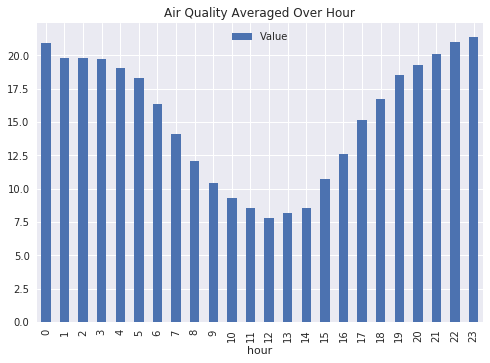

In [57]:
with plt.style.context(("ggplot", "seaborn")):
    air_sensor.groupby("hour").mean()[["Value"]].plot.bar(title="Air Quality Averaged Over Hour");

In [58]:
avg_air_censor_per_hour = air_sensor.groupby(["date_time"]).mean()[["Value"]].reset_index()
avg_air_censor_per_hour = avg_air_censor_per_hour.set_index("date_time")

avg_air_censor_per_hour.head(20)

Value
date_time                     
2019-05-22 05:00:00  33.545455
2019-05-22 06:00:00  30.722222
2019-05-22 07:00:00  28.058824
2019-05-22 08:00:00  25.562500
2019-05-22 09:00:00  24.076923
2019-05-22 10:00:00  22.047619
2019-05-22 11:00:00  19.800000
2019-05-22 12:00:00   9.166667
2019-05-22 13:00:00   9.800000
2019-05-22 14:00:00   5.400000
2019-05-22 15:00:00   9.066667
2019-05-22 16:00:00  15.625000
2019-05-22 17:00:00  18.400000
2019-05-22 18:00:00  20.200000
2019-05-22 19:00:00  25.000000
2019-05-22 20:00:00  25.750000
2019-05-22 22:00:00  24.000000
2019-05-22 23:00:00  26.500000
2019-05-23 00:00:00  25.500000
2019-05-23 01:00:00  23.666667

In [59]:
avg_air_censor_per_hour.tail()

Value
date_time                     
2019-07-01 01:00:00  27.428571
2019-07-01 02:00:00  27.857143
2019-07-01 03:00:00  28.421053
2019-07-01 04:00:00  29.600000
2019-07-01 05:00:00  29.571429

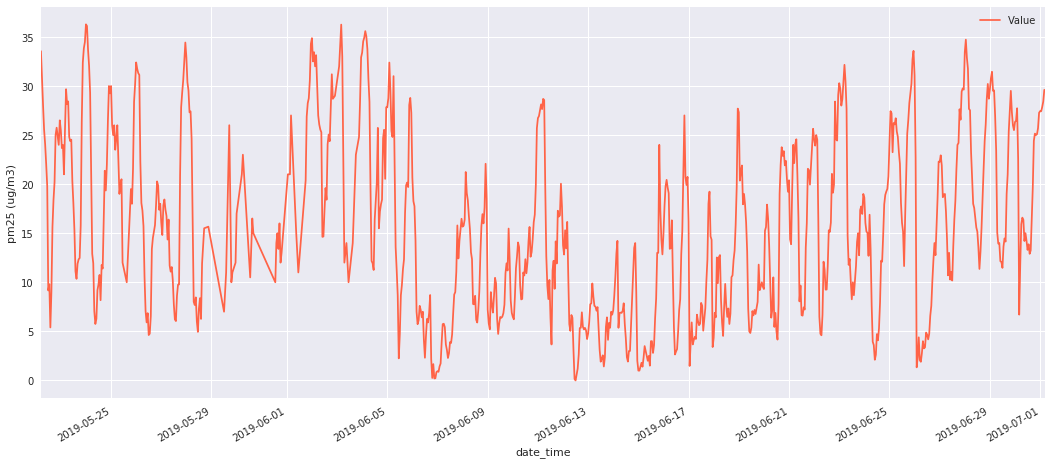

In [60]:
with plt.style.context(("ggplot", "seaborn")):
    avg_air_censor_per_hour.plot(y="Value", figsize=(18,8), c="tomato");
    plt.ylabel("pm25 (ug/m3)")

In [62]:
#from statsmodels.tsa.seasonal import seasonal_decompose

#decompose_result = seasonal_decompose(temp, freq="H")

#trend = decompose_result.trend
#seasonal = decompose_result.seasonal
#residual = decompose_result.resid

#decompose_result.plot();

#### ACF Chart

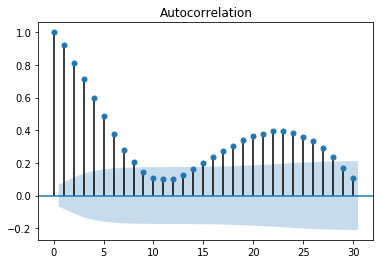

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(avg_air_censor_per_hour);

#### PACF Chart

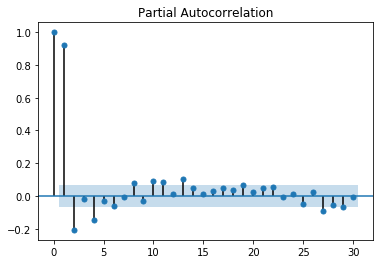

In [64]:
plot_pacf(avg_air_censor_per_hour);

#### Dicky-Fuller Test For Stationarity

In [65]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(avg_air_censor_per_hour["Value"].values)

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.583184990092307
2. P-Value :  0.00013870835701009914
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 847
5. Critical Values :
	 1% :  -3.438094071905401
	 5% :  -2.8649583643817227
	 10% :  -2.568590208277287


From our dicky-fuller test results, we can confirm that time-series is `STATIONARY` due to a p-value of `0.0001` less than `0.05`.

In [66]:
avg_air_censor_per_hour = avg_air_censor_per_hour["2019-5-22":"2019-06-30"]
avg_air_censor_per_hour

Value
date_time                     
2019-05-22 05:00:00  33.545455
2019-05-22 06:00:00  30.722222
2019-05-22 07:00:00  28.058824
2019-05-22 08:00:00  25.562500
2019-05-22 09:00:00  24.076923
...                        ...
2019-06-30 19:00:00  25.142857
2019-06-30 20:00:00  25.000000
2019-06-30 21:00:00  25.083333
2019-06-30 22:00:00  25.705882
2019-06-30 23:00:00  27.269231

[854 rows x 1 columns]

In [67]:
future_dt_range = pd.date_range(start="2019-7-1", end="2019-07-08", freq="H")[:-1]
future_dt_range[:3], future_dt_range[-3:]

(DatetimeIndex(['2019-07-01 00:00:00', '2019-07-01 01:00:00',
                '2019-07-01 02:00:00'],
               dtype='datetime64[ns]', freq='H'),
 DatetimeIndex(['2019-07-07 21:00:00', '2019-07-07 22:00:00',
                '2019-07-07 23:00:00'],
               dtype='datetime64[ns]', freq='H'))

In [68]:
X = avg_air_censor_per_hour["Value"].values# [1:] - avg_air_censor_per_hour["Value"].values[-1:]

history = [x for x in X]
predictions = list()



#last_value = avg_air_censor_per_hour["Value"].values[-1]
for t in range(7):
    model = ARIMA(history, order=(24,0,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=24)
    #output = model_fit.predict(len(X), len(X))
    #print(output)
    yhat = output[0]
    predictions.extend(yhat.tolist())
    history.extend(yhat.tolist())

In [69]:
predictions_df = pd.DataFrame(data={"Value": predictions}, index=future_dt_range)
predictions_df.head(20)

Value
2019-07-01 00:00:00  26.924533
2019-07-01 01:00:00  25.662193
2019-07-01 02:00:00  23.700480
2019-07-01 03:00:00  21.844728
2019-07-01 04:00:00  19.780069
2019-07-01 05:00:00  18.281995
2019-07-01 06:00:00  17.056866
2019-07-01 07:00:00  16.204743
2019-07-01 08:00:00  15.807818
2019-07-01 09:00:00  15.480003
2019-07-01 10:00:00  15.322456
2019-07-01 11:00:00  15.519521
2019-07-01 12:00:00  15.831967
2019-07-01 13:00:00  16.433250
2019-07-01 14:00:00  17.116858
2019-07-01 15:00:00  17.711726
2019-07-01 16:00:00  18.479526
2019-07-01 17:00:00  19.104995
2019-07-01 18:00:00  19.634178
2019-07-01 19:00:00  20.024567

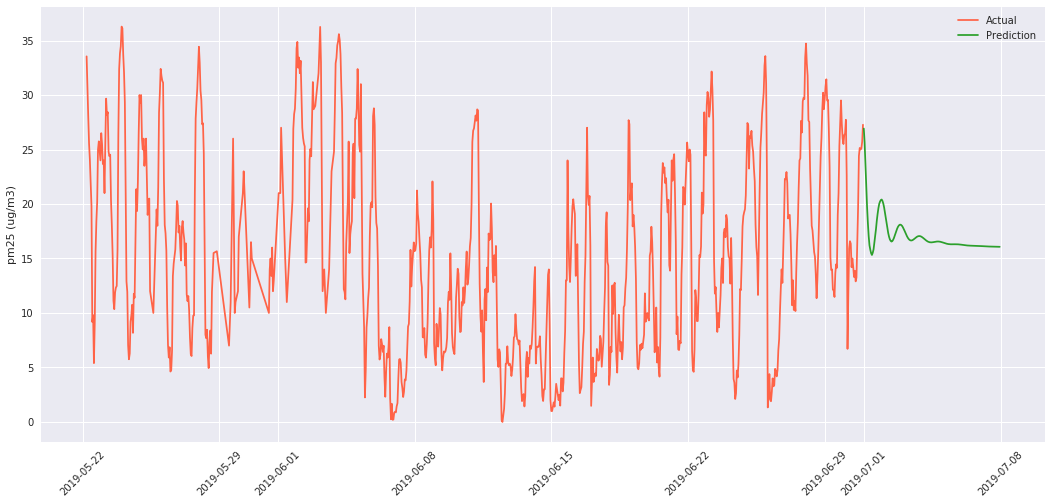

In [70]:
with plt.style.context(("ggplot", "seaborn")):
    fig = plt.figure(figsize=(18,8))
    plt.plot(avg_air_censor_per_hour.index, avg_air_censor_per_hour["Value"], c="tomato", label="Actual")
    plt.plot(predictions_df.index, predictions_df["Value"], c="tab:green", label="Prediction")
    plt.ylabel("pm25 (ug/m3)")
    plt.xticks(rotation=45)
    plt.legend(loc="best")

In [71]:
predictions_df.to_csv("air_quality.csv")

## Research Question 3A

In-line with Cyberview’s green aspirations, Boost will be launching a Low Carbon Mobility cross-sell campaign to promote the usage of Neuron Electric Scooter and GoCar’s fleet of Energy Efficient Vehicles (EEVs).
You are required to build a model to identify customers who are likely to be interested in the campaign as well as their preferred mode of transportation. Based on your model’s outcome, the quantity of resources e.g. cars, scooter, manpower, etc. will be allocated. The objective of this campaign is profit maximization rather than just the accuracy of the model as there is a revenue and cost impact for wrong predictions. For example, incorrectly allocating a GoCar results in losses such as cost of financing the car, parking fees, fuel consumption, etc. On the other hand, correctly predicting customer’s demand for the right vehicle generates revenue. 

The cost and revenue of each outcome are summarized below:


Actual/Predicted|Neuron scooter|GoCar|Not Interested
-|-|-|-
Neuron scooter|+ RM 70|- RM 40|- RM 10
GoCar|- RM 110|+ RM 330|- RM 120
Not Interested|- RM 10|- RM 30|+ RM 20

* Build a model that returns the highest profit, so that running this campaign meets this objective. Use the historical result stored in “past_result.csv” to train your prediction model. You are required to submit your model’s prediction result for each Customer ID in the holdout sample given in “potential_users.csv”.

In [72]:
past_campaign = pd.read_csv("Dataset/past_result.csv", sep="\t")
past_campaign = past_campaign.set_index("customer_id")
past_campaign.head()

campaign_outcome
customer_id                         
7278271474546681529   Not Interested
z296370477958436978   Not Interested
r911565982152448916   Not Interested
q186176853125629887   Not Interested
k482906940645133770   Not Interested

In [73]:
potential_customers = pd.read_csv("Dataset/potential_users.csv", sep="\t")
potential_customers = potential_customers.set_index("customer_id")
potential_customers.head()

Empty DataFrame
Columns: []
Index: [1004944629214078488, 1007484341585366249, 10260880631433629, 1030325007577212893, 1044219974303138367]

In [74]:
customer_data = pd.read_csv("Dataset/crm.csv", sep="\t")
customer_data = customer_data.set_index("customer_id")
customer_data.head(10)

customer_age   arpu                  model  gender
customer_id                                                            
1000018443372088799           NaN    NaN                    NaN     NaN
1000156262008373076           NaN    NaN                    NaN     NaN
1000224617298878347          23.0  56.70                Unknown  female
1000389532835354059          39.0  88.48              vivo Y91C    male
1000764230386201908           NaN    NaN                    NaN     NaN
1001382391835439367          24.0  45.00              SM-G935FD     NaN
100145068625335576           35.0  48.78  iPhone 7 Plus (A1784)    male
100145068625335576           38.0  91.57           vivo V15 Pro    male
1001941660439433129           NaN    NaN                    NaN     NaN
1001950042749209484          69.0  95.53             Nokia 3 DS  female

In [75]:
print("Average Customer Age : %.2f" %customer_data["customer_age"].mean())
print("Average Customer arpu : %.2f" %customer_data["arpu"].mean())
print("Customer ARPU Range : %.2f - %.2f"%(customer_data["arpu"].min(), customer_data["arpu"].max()))
sorted(Counter(customer_data["model"]).items(), key=lambda x: x[1], reverse=True)[:15]

Average Customer Age : 35.18
Average Customer arpu : 86.94
Customer ARPU Range : -80.08 - 12851.44


[(nan, 23570),
 ('UNKNOWN', 2838),
 ('iPhone 6 (A1586)', 1279),
 ('iPhone 7 Plus (A1784)', 950),
 ('iPhone 7 (A1778)', 860),
 ('iPhone 6S (A1688)', 780),
 ('iPhone X (A1901)', 666),
 ('nova 3i', 598),
 ('iPhone 8 Plus (A1897)', 517),
 ('Nova 2i', 511),
 ('iPhone 6S Plus (A1687)', 465),
 ('A3s', 452),
 ('SM-G532G DS', 451),
 ('iPhone 6 Plus (A1524)', 410),
 ('SM-G610F DS', 397)]

### Counting Average GTV of Customer Daily

In [76]:
avg_gtv_per_day = transactions.reset_index().groupby("customer_id").sum()[["GTV"]]/ len(dt_rng1)
avg_gtv_per_day.head()

GTV
customer_id                   
1000389532835354059  55.984516
100145068625335576   34.093871
1004944629214078488  79.127097
1005785517217042357  23.635484
1007407006287220756  41.815806

### Calculating Average GTV of Customer Daily per Merchant Category

In [77]:
avg_gtv_per_merchant_cat = pd.pivot_table(transactions, index="customer_id", columns="MerchantCategory", values="GTV")
avg_gtv_per_merchant_cat = avg_gtv_per_merchant_cat/len(dt_rng1)
avg_gtv_per_merchant_cat = avg_gtv_per_merchant_cat.fillna(0)
avg_gtv_per_merchant_cat.head()

MerchantCategory          F&B  Household Goods and Groceries    Retail  \
customer_id                                                              
1000389532835354059  2.200000                       1.713226  3.104793   
100145068625335576   1.661056                       0.000000  0.915645   
1004944629214078488  1.696205                       0.000000  3.219097   
1005785517217042357  1.733088                       1.327097  0.000000   
1007407006287220756  1.989153                       0.778548  1.633419   

MerchantCategory     Services  Transit & Travel  
customer_id                                      
1000389532835354059  1.737742          0.000000  
100145068625335576   1.398387          0.746280  
1004944629214078488  4.274516          0.000000  
1005785517217042357  0.000000          0.726912  
1007407006287220756  0.265161          0.000000

### Calculating Average Customers Subscribed Per Grid Daily

In [78]:
avg_grid_travel_daily = event_log.reset_index().groupby("customer_id").count()[["grid_id"]] / len(dt_rng1)
avg_grid_travel_daily.columns = ["Avg.Daily.Grid"]
avg_grid_travel_daily.head()

Avg.Daily.Grid
customer_id                        
1000018443372088799        0.032258
1000156262008373076        0.032258
1000224617298878347        0.129032
1000389532835354059        2.612903
1000764230386201908        0.032258

### Merging Customer Data with Past Campaign Results

In [79]:
past_campaign = past_campaign.join(customer_data)

past_campaign["gender"] = past_campaign["gender"].fillna("")
past_campaign["model"] = past_campaign["model"].fillna("")
past_campaign["customer_age"] = past_campaign["customer_age"].fillna(-1)
past_campaign["arpu"] = past_campaign["arpu"].fillna(-1)

past_campaign = past_campaign.join(avg_gtv_per_day)

past_campaign = past_campaign.join(avg_gtv_per_merchant_cat)

past_campaign = past_campaign.join(avg_grid_travel_daily)

past_campaign.head(10)

campaign_outcome  customer_age    arpu  \
customer_id                                                          
1000389532835354059           Not Interested          39.0   88.48   
100145068625335576                     GoCar          35.0   48.78   
100145068625335576                     GoCar          38.0   91.57   
1005785517217042357  Neuron electric scooter          29.0   81.26   
1007407006287220756           Not Interested          30.0  113.33   
100776946240884445            Not Interested          46.0   82.48   
1011477123846508308           Not Interested          47.0   57.97   
1014012754147981561  Neuron electric scooter          37.0  107.24   
1022664731215330163  Neuron electric scooter          39.0   84.75   
10258084199331447             Not Interested          35.0   55.33   

                                     model  gender        GTV       F&B  \
customer_id                                                               
1000389532835354059              vivo Y91C    male  55.984516  2.200000   
100145068625335576   iPhone 7 Plus (A1784)    male  34.093871  1.661056   
100145068625335576            vivo V15 Pro    male  34.093871  1.661056   
1005785517217042357                           male  23.635484  1.733088   
1007407006287220756                           male  41.815806  1.989153   
100776946240884445           Honor 10 Lite    male  47.385484  1.959462   
1011477123846508308         Huawei Mate 20    male  64.902258  2.629373   
1014012754147981561                           male  35.860000  1.339247   
1022664731215330163        Apple iPhone XR  female  63.924516  1.130108   
10258084199331447                 Oppo F11  female  31.831290  1.768405   

                     Household Goods and Groceries    Retail  Services  \
customer_id                                                              
1000389532835354059                       1.713226  3.104793  1.737742   
100145068625335576                        0.000000  0.915645  1.398387   
100145068625335576                        0.000000  0.915645  1.398387   
1005785517217042357                       1.327097  0.000000  0.000000   
1007407006287220756                       0.778548  1.633419  0.265161   
100776946240884445                        0.308065  2.666855  1.419677   
1011477123846508308                       0.000000  0.000000  2.928925   
1014012754147981561                       2.655376  2.593763  0.023871   
1022664731215330163                       1.414816  3.123871  1.457823   
10258084199331447                         0.000000  0.000000  0.000000   

                     Transit & Travel  Avg.Daily.Grid  
customer_id                                            
1000389532835354059          0.000000        2.612903  
100145068625335576           0.746280        3.548387  
100145068625335576           0.746280        3.548387  
1005785517217042357          0.726912        2.838710  
1007407006287220756          0.000000        3.000000  
100776946240884445           0.604041        3.645161  
1011477123846508308          0.000000        3.193548  
1014012754147981561          0.000000        2.548387  
1022664731215330163          0.000000        3.548387  
10258084199331447            0.000000        2.967742

### Merging Customer Data with Potential Customers

In [80]:
potential_customers = potential_customers.join(customer_data)

potential_customers["gender"] = potential_customers["gender"].fillna("")
potential_customers["model"] = potential_customers["model"].fillna("")
potential_customers["customer_age"] = potential_customers["customer_age"].fillna(-1)
potential_customers["arpu"] = potential_customers["arpu"].fillna(-1)

potential_customers = potential_customers.join(avg_gtv_per_day)

potential_customers = potential_customers.join(avg_gtv_per_merchant_cat)

potential_customers = potential_customers.join(avg_grid_travel_daily)

potential_customers.head(10)

customer_age    arpu              model  gender  \
customer_id                                                            
1004944629214078488          22.0   71.95   Xiaomi Mi 9T Pro    male   
1007484341585366249          -1.0   86.24                     female   
10260880631433629            49.0   53.36  Samsung Galaxy S9  female   
1030325007577212893          49.0   79.64   Xiaomi Mi 9T Pro    male   
1044219974303138367          -1.0   80.70            Redmi 7           
1044219974303138367          43.0  101.65            Oppo A7    male   
1047593864449596910          23.0  112.27                     female   
1049690052492334377          34.0  157.01           Oppo F11    male   
1069681154781330609          36.0   69.33                     female   
1091582193941185579          32.0   83.95     Huawei Nova 4e    male   

                            GTV       F&B  Household Goods and Groceries  \
customer_id                                                                
1004944629214078488   79.127097  1.696205                       0.000000   
1007484341585366249   32.207419  1.837419                       1.648710   
10260880631433629     69.144194  1.743091                       1.609120   
1030325007577212893   53.201290  2.284113                       0.000000   
1044219974303138367   33.590968  1.129140                       1.231935   
1044219974303138367   33.590968  1.129140                       1.231935   
1047593864449596910   31.948710  1.558423                       0.663656   
1049690052492334377  110.179355  3.245634                       2.263355   
1069681154781330609   59.605161  1.890161                       1.665581   
1091582193941185579   75.184194  3.083327                       0.856935   

                       Retail  Services  Transit & Travel  Avg.Daily.Grid  
customer_id                                                                
1004944629214078488  3.219097  4.274516          0.000000        3.451613  
1007484341585366249  2.853226  0.801613          0.845732        2.580645  
10260880631433629    2.245282  2.094086          0.000000        3.677419  
1030325007577212893  0.000000  2.506344          0.000000        3.290323  
1044219974303138367  4.233548  0.000000          0.991042        2.870968  
1044219974303138367  4.233548  0.000000          0.991042        2.870968  
1047593864449596910  1.071548  0.120000          0.940358        3.677419  
1049690052492334377  9.514452  1.302903          0.000000        3.000000  
1069681154781330609  2.490452  1.008710          0.000000        3.096774  
1091582193941185579  2.889770  2.194839          0.000000        3.096774

### One Hot Encode `Mobile` & `Gender` Columns

In [81]:
from sklearn.preprocessing import OneHotEncoder

In [82]:
encoder = OneHotEncoder(handle_unknown="ignore")

one_hot_encoded = encoder.fit_transform(past_campaign[["model", "gender"]])

In [83]:
holdout_data = encoder.transform(potential_customers[["model", "gender"]])

### Create Final Dataset With All Columns

* customer_age
* arpu
* GTV
* F&B
* Household Goods and Groceries
* Retail
* Services
* Transit & Travel
* Avg.Daily.Cust

In [84]:
X = np.hstack((past_campaign[["customer_age", "arpu", "GTV", "F&B","Household Goods and Groceries","Retail","Services","Transit & Travel", "Avg.Daily.Grid"]].values, one_hot_encoded.toarray()))
X_potential = np.hstack((potential_customers[["customer_age", "arpu", "GTV", "F&B","Household Goods and Groceries","Retail","Services","Transit & Travel", "Avg.Daily.Grid"]].values, holdout_data.toarray()))
Y = past_campaign["campaign_outcome"].values

print(X.shape, Y.shape, X_potential.shape)

(6149, 174) (6149,) (2627, 174)


### Dividing Data into Train/Test Sets

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import scikitplot as skplt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    train_size=0.70,
                                                    test_size=0.30,
                                                    stratify=Y, 
                                                    random_state=123)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(4304, 174) (1845, 174) (4304,) (1845,)


In [87]:
from collections import Counter

pd.DataFrame([Counter(Y_train)]) *100 / len(Y_train)

Not Interested  Neuron electric scooter     GoCar
0            62.5                34.433086  3.066914

In [88]:
pd.DataFrame([Counter(Y_test)]) * 100 / len(Y_test)

Neuron electric scooter  Not Interested    GoCar
0                34.471545       62.493225  3.03523

In [89]:
pd.DataFrame([Counter(Y)]) * 100 / len(Y)

Not Interested     GoCar  Neuron electric scooter
0       62.497967  3.057408                34.444625

### Logistic Regression

In [90]:
lr = LogisticRegression()

lr.fit(X_train, Y_train)

lr.score(X_train, Y_train), lr.score(X_test, Y_test)

(0.8025092936802974, 0.8043360433604336)

                         precision    recall  f1-score   support

                  GoCar       0.70      0.29      0.41        56
Neuron electric scooter       0.81      0.64      0.71       636
         Not Interested       0.81      0.92      0.86      1153

               accuracy                           0.80      1845
              macro avg       0.77      0.61      0.66      1845
           weighted avg       0.80      0.80      0.79      1845



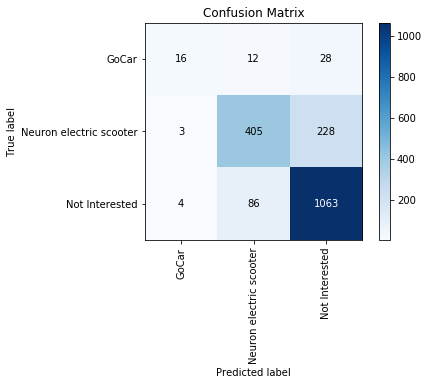

In [91]:
print(classification_report(Y_test, lr.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, lr.predict(X_test));
plt.xticks(rotation=90);

#### Cost on Test Data

In [92]:
def calculate_revenue(Y_test, Y_preds):
    cost = [[330, -40, -30],
            [-110, 70, -10],
            [-120, -10, 20]]
    return (confusion_matrix(Y_test, Y_preds) * cost).sum()

calculate_revenue(Y_test, lr.predict(X_test))

49620

In [93]:
pd.DataFrame([Counter(lr.predict(X_potential))]) * 100 / X_potential.shape[0]

Not Interested  Neuron electric scooter     GoCar
0       71.869052                26.950895  1.180053

### Random Forest

In [94]:
rf = RandomForestClassifier()

rf.fit(X_train, Y_train)

rf.score(X_train, Y_train), rf.score(X_test, Y_test)

(0.9921003717472119, 0.8444444444444444)

                         precision    recall  f1-score   support

                  GoCar       0.64      0.25      0.36        56
Neuron electric scooter       0.83      0.77      0.80       636
         Not Interested       0.86      0.92      0.88      1153

               accuracy                           0.84      1845
              macro avg       0.77      0.64      0.68      1845
           weighted avg       0.84      0.84      0.84      1845



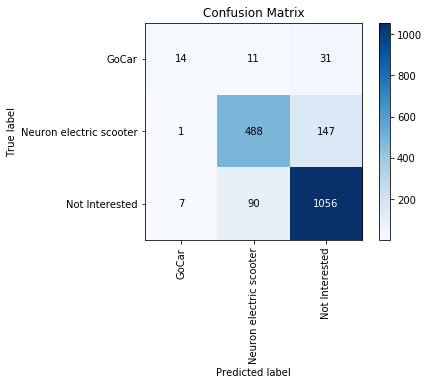

In [95]:
print(classification_report(Y_test, rf.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, rf.predict(X_test));
plt.xticks(rotation=90);

#### Cost on Test Data

In [96]:
calculate_revenue(Y_test, rf.predict(X_test))

55210

In [97]:
pd.DataFrame([Counter(rf.predict(X_potential))]) * 100 / X_potential.shape[0]

Not Interested  Neuron electric scooter     GoCar
0       66.692044                31.975638  1.332318

### Gradient Boosting

In [98]:
gb = GradientBoostingClassifier(n_estimators=50, criterion="mse", max_features=0.90, max_depth=3, learning_rate=0.2, random_state=1)

gb.fit(X_train, Y_train)

gb.score(X_train, Y_train), gb.score(X_test, Y_test)

(0.8968401486988847, 0.8634146341463415)

                         precision    recall  f1-score   support

                  GoCar       0.69      0.52      0.59        56
Neuron electric scooter       0.86      0.78      0.82       636
         Not Interested       0.87      0.93      0.90      1153

               accuracy                           0.86      1845
              macro avg       0.81      0.74      0.77      1845
           weighted avg       0.86      0.86      0.86      1845



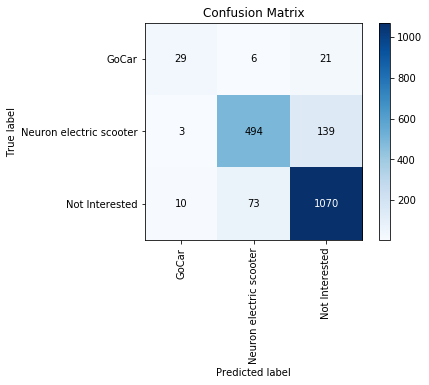

In [99]:
print(classification_report(Y_test, gb.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, gb.predict(X_test))
plt.xticks(rotation=90);

#### Cost on Test Data

In [100]:
calculate_revenue(Y_test, gb.predict(X_test))

61030

In [101]:
pd.DataFrame([Counter(gb.predict(X_potential))]) * 100 / X_potential.shape[0]

Not Interested  Neuron electric scooter    GoCar
0        67.94823                 30.03426  2.01751

In [102]:
gadient_boosting_potential_preds = pd.DataFrame(data={"CustomerInterest":gb.predict(X_potential)}, index=potential_customers.index)
gadient_boosting_potential_preds.head()

CustomerInterest
customer_id                                 
1004944629214078488           Not Interested
1007484341585366249  Neuron electric scooter
10260880631433629    Neuron electric scooter
1030325007577212893           Not Interested
1044219974303138367  Neuron electric scooter

In [103]:
gadient_boosting_potential_preds.to_csv("Gradient_Boosting_Potential_Customers_Interest.csv")

### Adaptive Boosting

In [104]:
adb = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=100, learning_rate=0.8)

adb.fit(X_train, Y_train)

adb.score(X_train, Y_train), adb.score(X_test, Y_test)

(0.7704460966542751, 0.7777777777777778)

                         precision    recall  f1-score   support

                  GoCar       0.70      0.29      0.41        56
Neuron electric scooter       0.79      0.55      0.65       636
         Not Interested       0.77      0.93      0.84      1153

               accuracy                           0.78      1845
              macro avg       0.75      0.59      0.63      1845
           weighted avg       0.78      0.78      0.76      1845



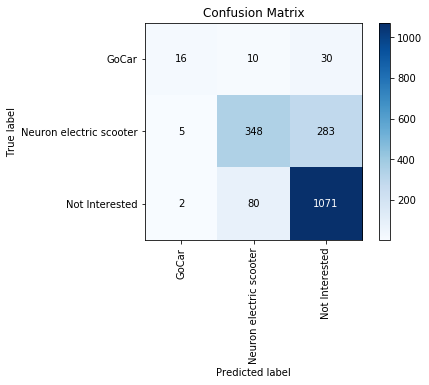

In [105]:
print(classification_report(Y_test, adb.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, adb.predict(X_test));
plt.xticks(rotation=90);

#### Cost on Test Data

In [106]:
calculate_revenue(Y_test, adb.predict(X_test))

45340

In [107]:
pd.DataFrame([Counter(adb.predict(X_potential))]) * 100 / X_potential.shape[0]

Not Interested  Neuron electric scooter     GoCar
0       75.866007                22.611344  1.522649

### Decision Tree

In [108]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=10)

dt.fit(X_train, Y_train)

dt.score(X_train, Y_train), dt.score(X_test, Y_test)

(0.9342472118959108, 0.8319783197831978)

                         precision    recall  f1-score   support

                  GoCar       0.55      0.46      0.50        56
Neuron electric scooter       0.79      0.76      0.78       636
         Not Interested       0.86      0.89      0.88      1153

               accuracy                           0.83      1845
              macro avg       0.74      0.70      0.72      1845
           weighted avg       0.83      0.83      0.83      1845



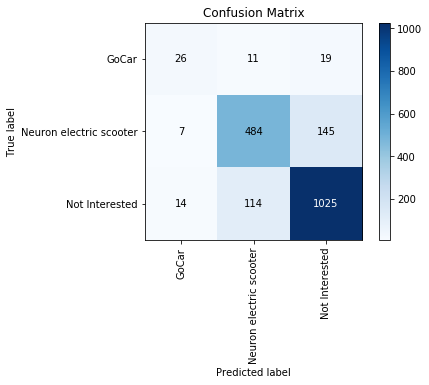

In [109]:
print(classification_report(Y_test, dt.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, dt.predict(X_test));
plt.xticks(rotation=90);

#### Cost on Test Data

In [110]:
calculate_revenue(Y_test, dt.predict(X_test))

56910

In [111]:
pd.DataFrame([Counter(dt.predict(X_potential))]) * 100 / X_potential.shape[0]

Neuron electric scooter  Not Interested     GoCar
0                31.899505       65.930719  2.169775

### Extra Tree Classifier

In [112]:
et = ExtraTreeClassifier(criterion="entropy", max_features="log2", class_weight={"GoCar":0.10, "Neuron electric scooter":0.30, "Not Interested":0.60})

et.fit(X_train, Y_train)

et.score(X_train, Y_train), et.score(X_test, Y_test)

(1.0, 0.71869918699187)

                         precision    recall  f1-score   support

                  GoCar       0.26      0.21      0.23        56
Neuron electric scooter       0.64      0.65      0.64       636
         Not Interested       0.78      0.78      0.78      1153

               accuracy                           0.72      1845
              macro avg       0.56      0.55      0.55      1845
           weighted avg       0.72      0.72      0.72      1845



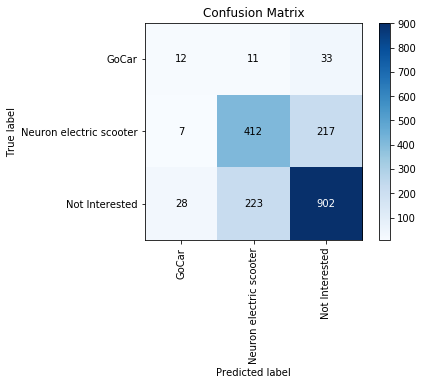

In [113]:
print(classification_report(Y_test, et.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, et.predict(X_test));
plt.xticks(rotation=90);

#### Cost on Test Data

In [114]:
calculate_revenue(Y_test, et.predict(X_test))

40880

In [115]:
pd.DataFrame([Counter(et.predict(X_potential))]) * 100 / X_potential.shape[0]

Not Interested  Neuron electric scooter     GoCar
0       63.266083                33.764751  2.969166

### Extra Trees Classifier

In [116]:
ets = ExtraTreesClassifier(n_estimators=20, criterion="entropy", max_features=0.95, random_state=12)

ets.fit(X_train, Y_train)

ets.score(X_train, Y_train), ets.score(X_test, Y_test)

(1.0, 0.865040650406504)

                         precision    recall  f1-score   support

                  GoCar       0.69      0.55      0.61        56
Neuron electric scooter       0.86      0.79      0.82       636
         Not Interested       0.88      0.92      0.90      1153

               accuracy                           0.87      1845
              macro avg       0.81      0.75      0.78      1845
           weighted avg       0.86      0.87      0.86      1845



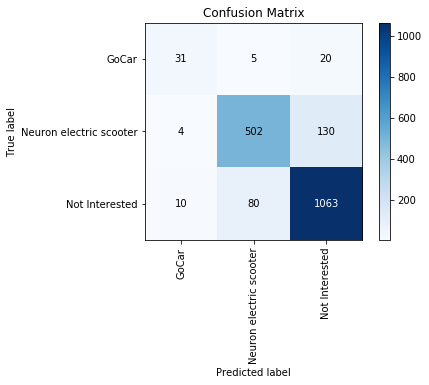

In [117]:
print(classification_report(Y_test, ets.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, ets.predict(X_test));
plt.xticks(rotation=90);

#### Cost on Test Data

In [118]:
calculate_revenue(Y_test, ets.predict(X_test))

62090

In [119]:
pd.DataFrame([Counter(ets.predict(X_potential))]) * 100 / X_potential.shape[0]

Not Interested  Neuron electric scooter     GoCar
0       66.121051                31.899505  1.979444

In [120]:
extra_trees_potential_preds = pd.DataFrame(data={"CustomerInterest":ets.predict(X_potential)}, index=potential_customers.index)
extra_trees_potential_preds.head()

CustomerInterest
customer_id                                 
1004944629214078488           Not Interested
1007484341585366249  Neuron electric scooter
10260880631433629             Not Interested
1030325007577212893           Not Interested
1044219974303138367  Neuron electric scooter

In [121]:
extra_trees_potential_preds.to_csv("Extra_Trees_Potential_Customers_Interest.csv")

### Multi-Layer Perceptron Classifier

In [122]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100))

mlp.fit(X_train, Y_train)

mlp.score(X_train, Y_train), mlp.score(X_test, Y_test)

(0.9479553903345725, 0.7967479674796748)

                         precision    recall  f1-score   support

                  GoCar       0.57      0.41      0.48        56
Neuron electric scooter       0.72      0.75      0.74       636
         Not Interested       0.85      0.84      0.84      1153

               accuracy                           0.80      1845
              macro avg       0.72      0.67      0.69      1845
           weighted avg       0.80      0.80      0.80      1845



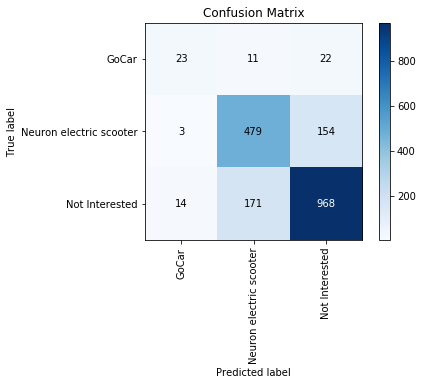

In [123]:
print(classification_report(Y_test, mlp.predict(X_test)))

skplt.metrics.plot_confusion_matrix(Y_test, mlp.predict(X_test));
plt.xticks(rotation=90);

#### Cost on Test Data

In [124]:
calculate_revenue(Y_test, mlp.predict(X_test))

54120

In [125]:
pd.DataFrame([Counter(mlp.predict(X_potential))]) * 100 / X_potential.shape[0]

Not Interested  Neuron electric scooter     GoCar
0       63.608679                34.640274  1.751047

In [126]:
past_neuron = past_campaign[past_campaign["campaign_outcome"] == "Neuron electric scooter"][["campaign_outcome"]]

potential_customers["campaign_outcome"] = gb.predict(X_potential)
potential_neuron = past_campaign[past_campaign["campaign_outcome"] == "Neuron electric scooter"][["campaign_outcome"]]

neuron_scooter_interested_citizens = pd.concat((past_neuron, potential_neuron))

event_log_cust_id = event_log.reset_index().set_index("customer_id")

neuron_citizens_with_daily_travel = neuron_scooter_interested_citizens.join(event_log_cust_id)

neuron_citizens_with_daily_travel["date"] = [dt.date() for dt in neuron_citizens_with_daily_travel["date_time"]]

neuron_citizens_with_daily_travel = neuron_citizens_with_daily_travel.reset_index()


def get_neuron_interested_users_path_by_date(dt=datetime.date(2019,7,19)):
    paths_travelled = []
    for df in neuron_citizens_with_daily_travel.groupby(["date", "customer_id"]):
        if df[0][0] == dt:
            paths_travelled.append(df[1]["grid_id"].values.tolist())

    neuron_unique_routes = []
    neuron_routes_with_count = []
    for route in paths_travelled:
        if route not in neuron_unique_routes:
                neuron_unique_routes.append(route)
                neuron_routes_with_count.append([route, paths_travelled.count(route)])
    return neuron_unique_routes, neuron_routes_with_count

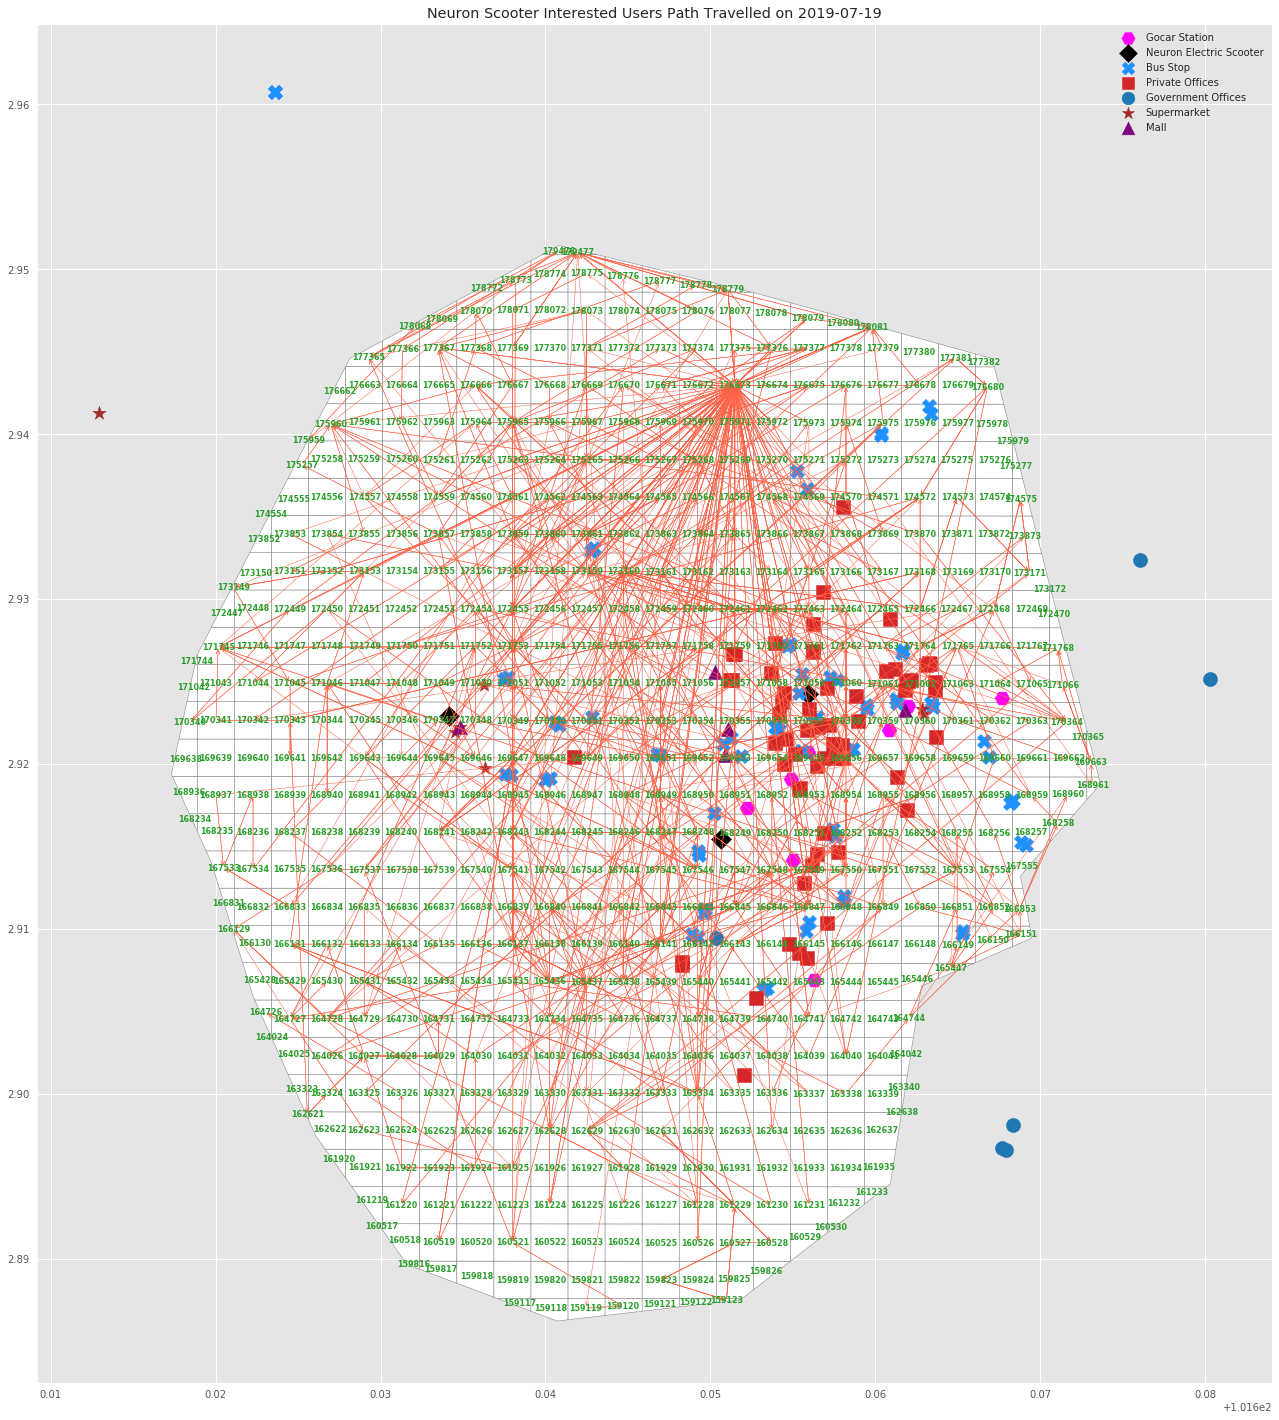

In [127]:
dt = datetime.date(2019,7,19)
neuron_unique_routes, neuron_routes_with_count = get_neuron_interested_users_path_by_date(dt)

def plot_neuron_scotter_interested_user_travel_for_particular_day():
    with plt.style.context(("seaborn", "ggplot")):
        grid_gpd.plot(figsize=(25,25), color="white", edgecolor="grey");

        for route, cnt in random.choices(neuron_routes_with_count, k=200):
            route_X, route_Y = get_route_centroids(route)
            for i, (x, y) in enumerate(list(zip(route_X, route_Y))[:-1]): 
                plt.annotate("", xytext=(x, y), 
                     xy=(route_X[i+1], route_Y[i+1]), 
                     xycoords='data',
                     textcoords='data',
                     arrowprops=dict(arrowstyle="->",  connectionstyle="arc3", color="tomato",))

        route_X, route_Y = get_route_centroids(grid_gpd.grid_id.values)
        for i in range(len(route_X)):
            plt.text(route_X[i], route_Y[i], s="%d"%(grid_gpd.grid_id.values[i]), ha="center", va="center", fontsize=8, color="tab:green", weight="bold")

        go_cars = transport_locations[transport_locations["POI Name"].str.startswith("Gocar Station")]
        plt.scatter(go_cars["Longitude"], go_cars["Latitude"], c="magenta", alpha=1.0, marker="H", s=220, label="Gocar Station")

        scooters = transport_locations[transport_locations["POI Name"].str.startswith("Neuron electric scooter Station")]
        plt.scatter(scooters["Longitude"], scooters["Latitude"], c="black", alpha=1.0, marker="D", s=200, label="Neuron Electric Scooter")

        bus_stops = transport_locations[transport_locations["POI Name"].str.startswith("bus stop")]
        plt.scatter(bus_stops["Longitude"], bus_stops["Latitude"], c="dodgerblue", marker="X", alpha=1.0, s=200, label="Bus Stop")
        
        plt.scatter(x=private["Longitude"], y=private["Latitude"], s=200, c="tab:red", alpha=1.0, marker="s", label="Private Offices")
        plt.scatter(x=govt["Longitude"], y=govt["Latitude"], s=200, c="tab:blue", alpha=1.0, label="Government Offices")
        plt.scatter(x=supermarket["Longitude"], y=supermarket["Latitude"], s=200, c="brown", alpha=1.0, marker="*", label="Supermarket")
        plt.scatter(x=mall["Longitude"], y=mall["Latitude"], s=200, c="purple", alpha=1.0, label="Mall", marker="^")
        
        plt.legend(loc="best", markerscale=0.9,)
        plt.title("Neuron Scooter Interested Users Path Travelled on %s"%str(dt))
        
        plt.savefig("neuron_scooter_interested_users_travel_on_%s"%str(dt))
        
plot_neuron_scotter_interested_user_travel_for_particular_day()

118


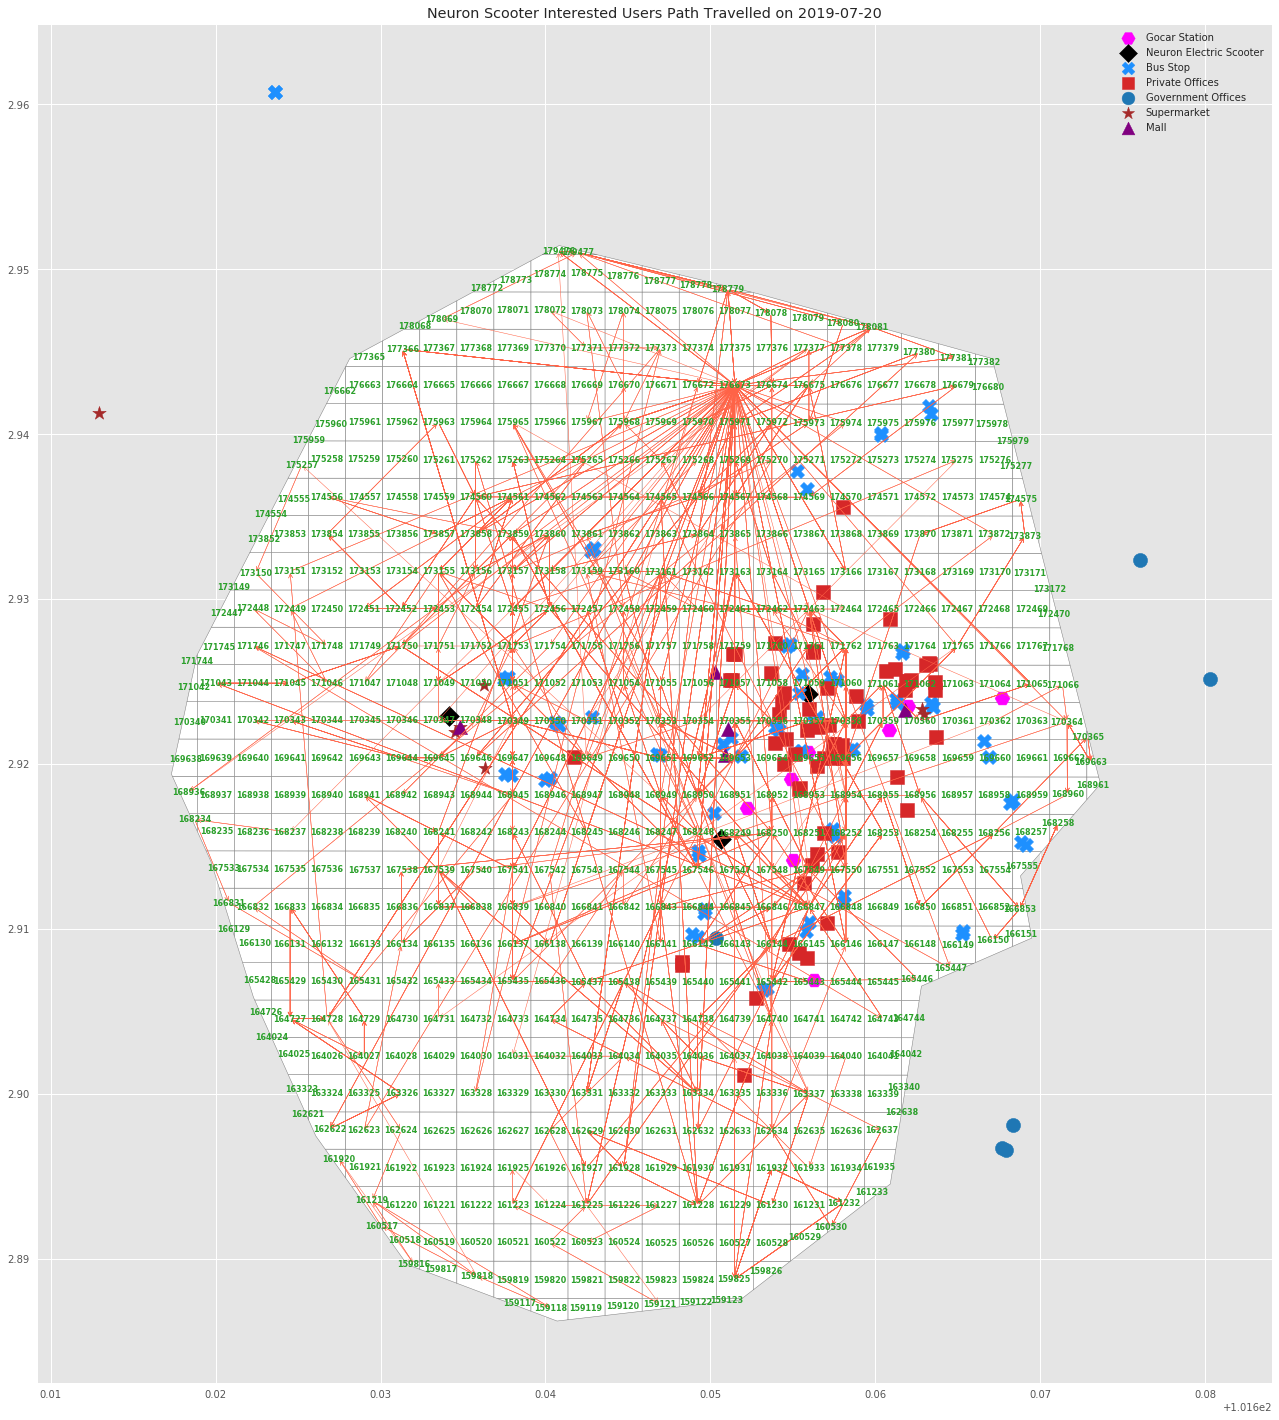

In [128]:
dt = datetime.date(2019,7,20)
neuron_unique_routes, neuron_routes_with_count = get_neuron_interested_users_path_by_date(dt)

print(len(neuron_unique_routes))

plot_neuron_scotter_interested_user_travel_for_particular_day()

In [129]:
past_gocar = past_campaign[past_campaign["campaign_outcome"] == "GoCar"][["campaign_outcome"]]

potential_customers["campaign_outcome"] = gb.predict(X_potential)
potential_gocar = past_campaign[past_campaign["campaign_outcome"] == "GoCar"][["campaign_outcome"]]

gocar_interested_citizens = pd.concat((past_gocar, potential_gocar))

event_log_cust_id = event_log.reset_index().set_index("customer_id")

gocar_citizens_with_daily_travel = gocar_interested_citizens.join(event_log_cust_id)

gocar_citizens_with_daily_travel["date"] = [dt.date() for dt in gocar_citizens_with_daily_travel["date_time"]]

gocar_citizens_with_daily_travel = gocar_citizens_with_daily_travel.reset_index()

def get_gocar_interested_users_path_by_date(dt=datetime.date(2019,7,19)):
    paths_travelled = []
    for df in gocar_citizens_with_daily_travel.groupby(["date", "customer_id"]):
        if df[0][0] == dt:
            paths_travelled.append(df[1]["grid_id"].values.tolist())

    gocar_unique_routes = []
    gocar_routes_with_count = []
    for route in paths_travelled:
        if route not in gocar_unique_routes:
                gocar_unique_routes.append(route)
                gocar_routes_with_count.append([route, paths_travelled.count(route)])
    
    return gocar_unique_routes, gocar_routes_with_count

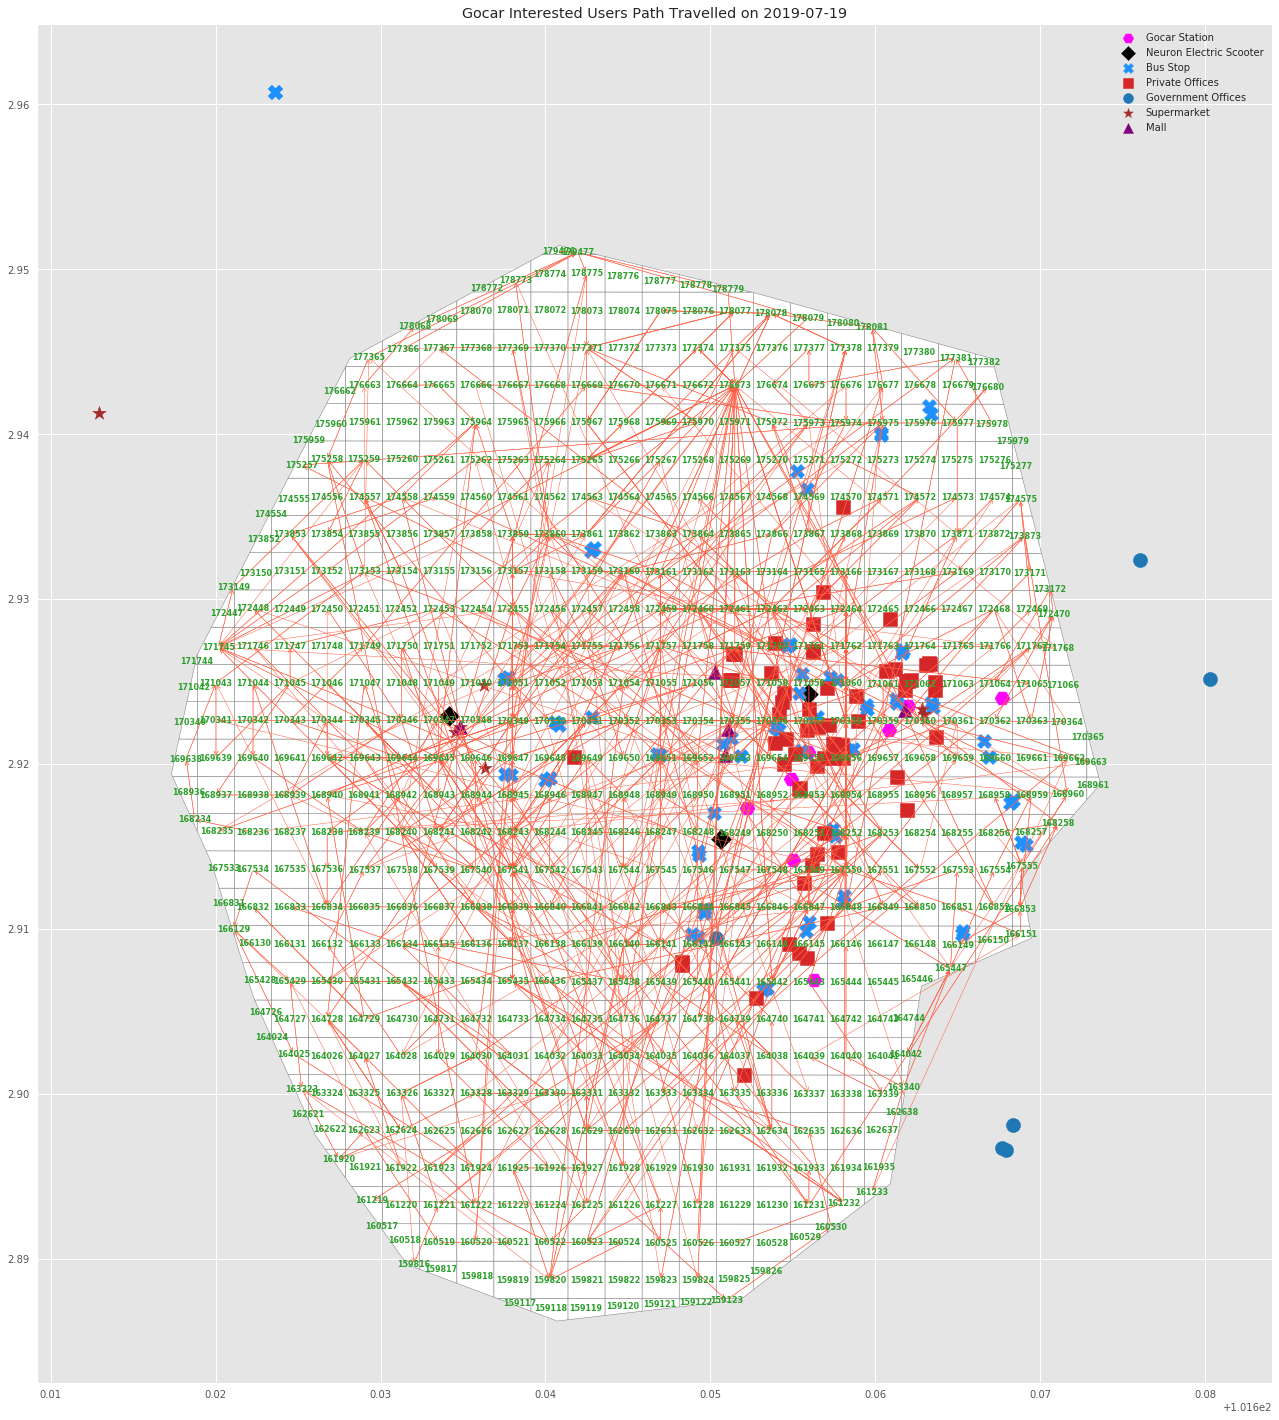

In [130]:
dt = datetime.date(2019,7,19)
gocar_unique_routes, gocar_routes_with_count = get_gocar_interested_users_path_by_date(dt)

def plot_gocar_interested_user_travel_for_particular_day():
    with plt.style.context(("seaborn", "ggplot")):
        grid_gpd.plot(figsize=(25,25), color="white", edgecolor="grey");

        for route, cnt in gocar_routes_with_count:
            route_X, route_Y = get_route_centroids(route)
            for i, (x, y) in enumerate(list(zip(route_X, route_Y))[:-1]): 
                plt.annotate("", xytext=(x, y), 
                     xy=(route_X[i+1], route_Y[i+1]), 
                     xycoords='data',
                     textcoords='data',
                     arrowprops=dict(arrowstyle="->",  connectionstyle="arc3", color="tomato"))

        route_X, route_Y = get_route_centroids(grid_gpd.grid_id.values)
        for i in range(len(route_X)):
            plt.text(route_X[i], route_Y[i], s="%d"%(grid_gpd.grid_id.values[i]), ha="center", va="center", fontsize=8, color="tab:green", weight="bold")
        
        go_cars = transport_locations[transport_locations["POI Name"].str.startswith("Gocar Station")]
        plt.scatter(go_cars["Longitude"], go_cars["Latitude"], c="magenta", alpha=1.0, marker="H", s=220, label="Gocar Station")

        scooters = transport_locations[transport_locations["POI Name"].str.startswith("Neuron electric scooter Station")]
        plt.scatter(scooters["Longitude"], scooters["Latitude"], c="black", alpha=1.0, marker="D", s=200, label="Neuron Electric Scooter")

        bus_stops = transport_locations[transport_locations["POI Name"].str.startswith("bus stop")]
        plt.scatter(bus_stops["Longitude"], bus_stops["Latitude"], c="dodgerblue", marker="X", alpha=1.0, s=200, label="Bus Stop")
        
        plt.scatter(x=private["Longitude"], y=private["Latitude"], s=200, c="tab:red", alpha=1.0, marker="s", label="Private Offices")
        plt.scatter(x=govt["Longitude"], y=govt["Latitude"], s=200, c="tab:blue", alpha=1.0, label="Government Offices")
        plt.scatter(x=supermarket["Longitude"], y=supermarket["Latitude"], s=200, c="brown", alpha=1.0, marker="*", label="Supermarket")
        plt.scatter(x=mall["Longitude"], y=mall["Latitude"], s=200, c="purple", alpha=1.0, label="Mall", marker="^")
        
        plt.legend(loc="best", markerscale=0.7,)
        
        plt.title("Gocar Interested Users Path Travelled on %s"%(dt))
        
        plt.savefig("gocar_interested_users_travel_on_%s"%str(dt))
        
plot_gocar_interested_user_travel_for_particular_day()

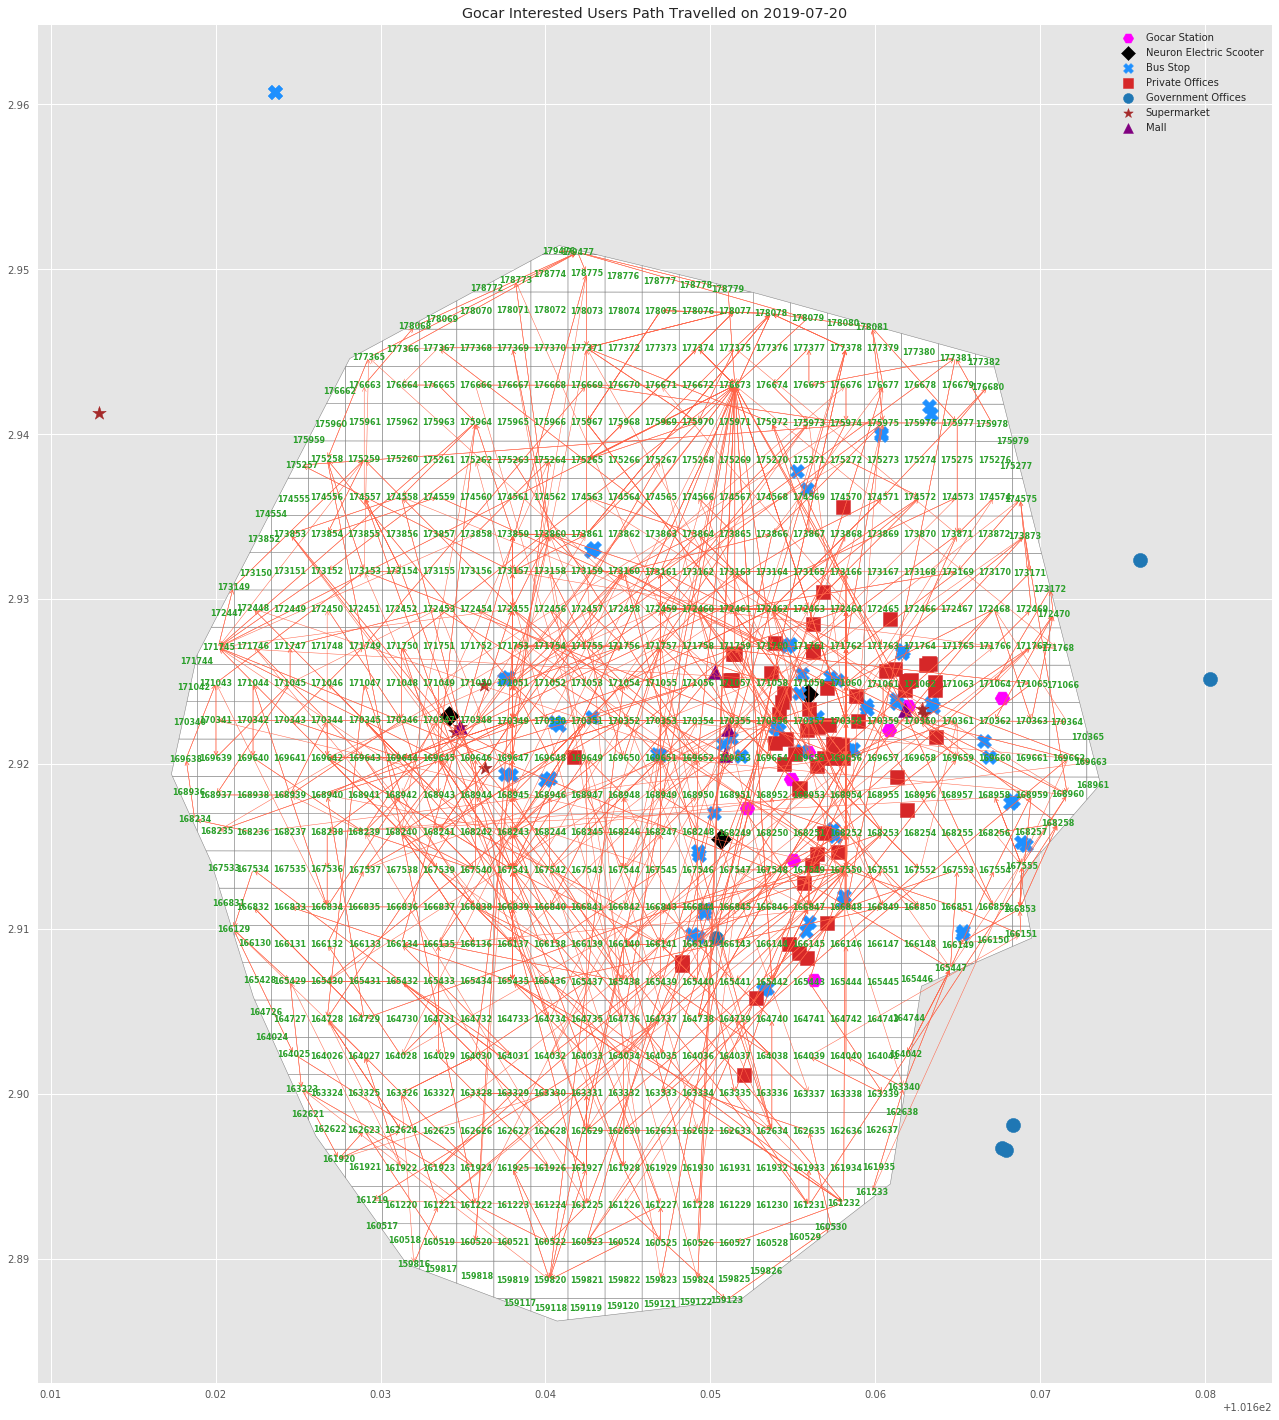

In [131]:
dt = datetime.date(2019,7,20)
gocar_unique_routes, gocar_routes_with_count = get_gocar_interested_users_path_by_date()

plot_gocar_interested_user_travel_for_particular_day()